In [3]:

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy.timeseries import TimeSeries, aggregate_downsample
from astropy.coordinates import match_coordinates_sky as coords
from astropy.coordinates import SpectralCoord
import astropy.units as u
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from mid_IR_variables import fileIO_processing as fp
from mid_IR_variables import lightcurve_processing as lp
from mid_IR_variables import ZTF_lightcurve_processing as zlp
from mid_IR_variables import reverberation_mapper 
from mid_IR_variables import MCMC_sampler


from sklearn.gaussian_process import GaussianProcessRegressor, kernels

from scipy import optimize
import scipy.stats as stats

import os

import corner

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

SAVE_FILEPATH = 'C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Figures/'
IMPORT_FILEPATH ='C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/'

mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data
tab = Table.read('reverb_lags_run3.txt', format='ascii.ipac')


In [8]:
pifus = tab['plateifu']
tab[tab['plateifu']=='7977-9101']


plateifu,lag_w1,amp_w1,const_w1,lag_w2,amp_w2,const_w2,lag_w1_yerr_min,lag_w1_yerr_max,lag_w2_yerr_min,lag_w2_yerr_max
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
7977-9101,17.5316256,1.1953787278363595,14.231139129001791,84.73619040000001,1.5587900515557804,14.51728632378981,22.049831569611438,24.499588479241716,27.7951167439588,25.194908542651632


In [9]:
AP04_spec = fits.open(r"C:\Users\paiaa\Documents\Research\Blanton Lab\Models\SDSS models\kc-spec-0.3.1-AP04.fits")
AP06_spec = fits.open(r"C:\Users\paiaa\Documents\Research\Blanton Lab\Models\SDSS models\kc-spec-0.3.1-AP06.fits")
AP08_spec = fits.open(r"C:\Users\paiaa\Documents\Research\Blanton Lab\Models\SDSS models\kc-spec-0.3.1-AP08.fits")

mnsa3_1_file = fits.open(r"C:\Users\paiaa\Documents\Research\Blanton Lab\Models\SDSS models\mnsa-0.3.1.fits")
mnsa_AP04 = mnsa3_1_file[5].data
mnsa_AP06 = mnsa3_1_file[7].data
mnsa_AP08 = mnsa3_1_file[9].data

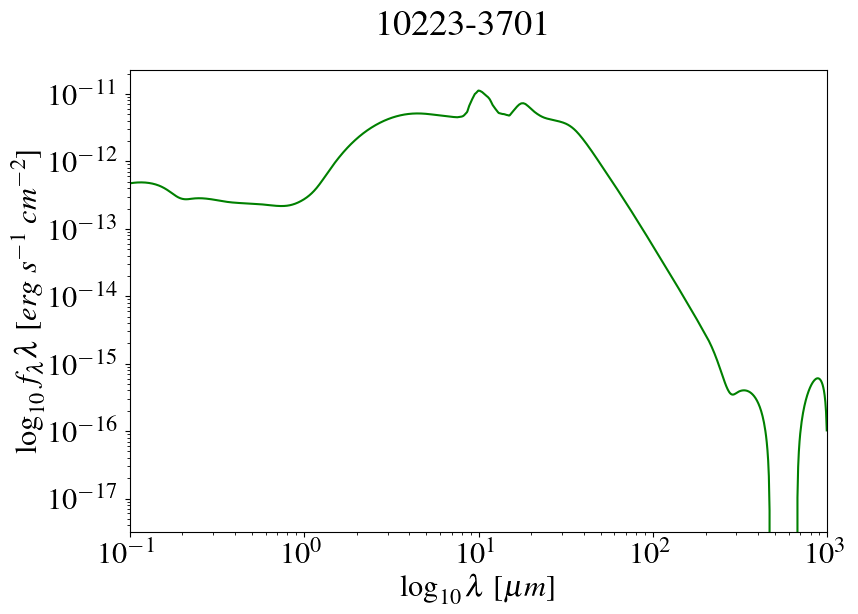

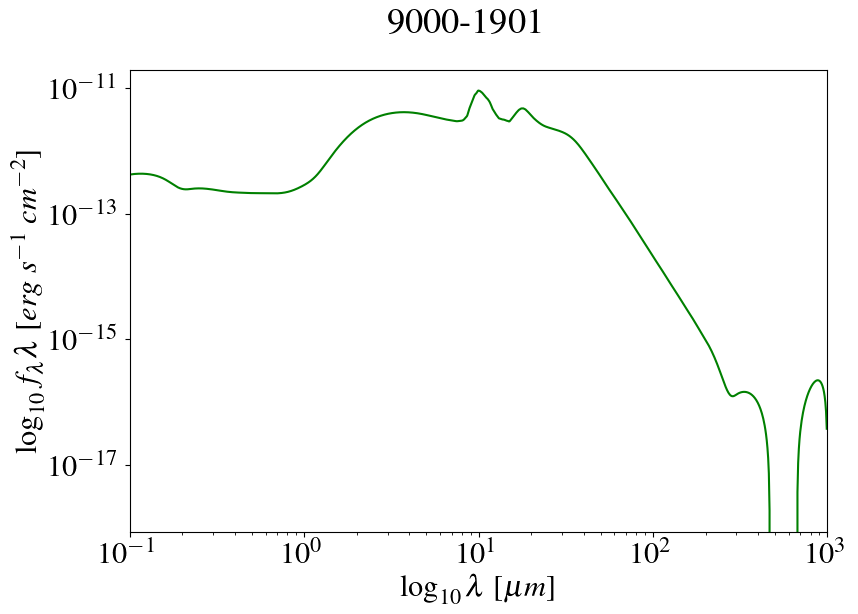

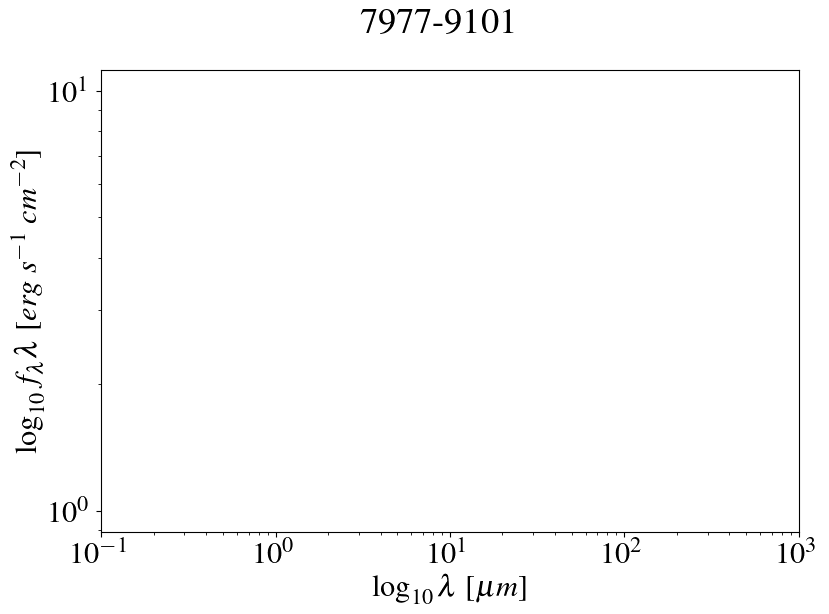

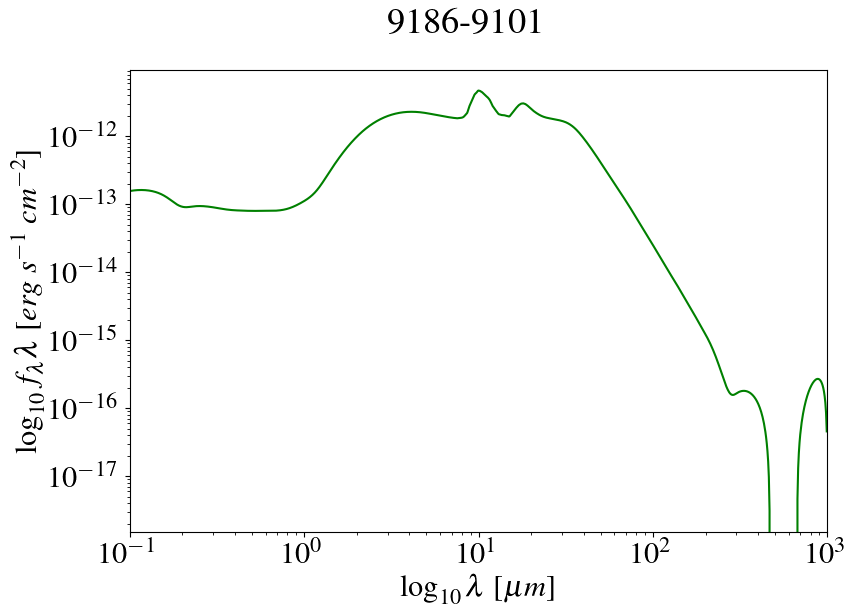

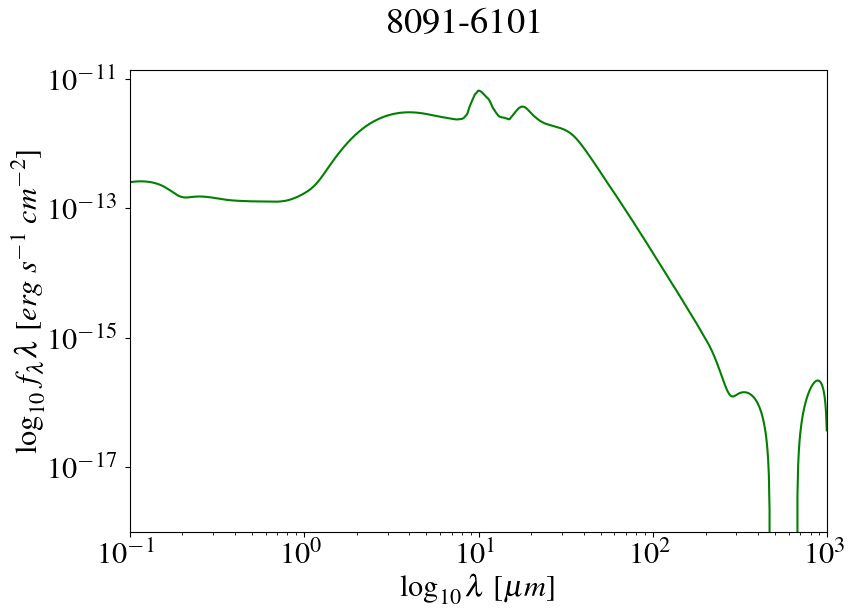

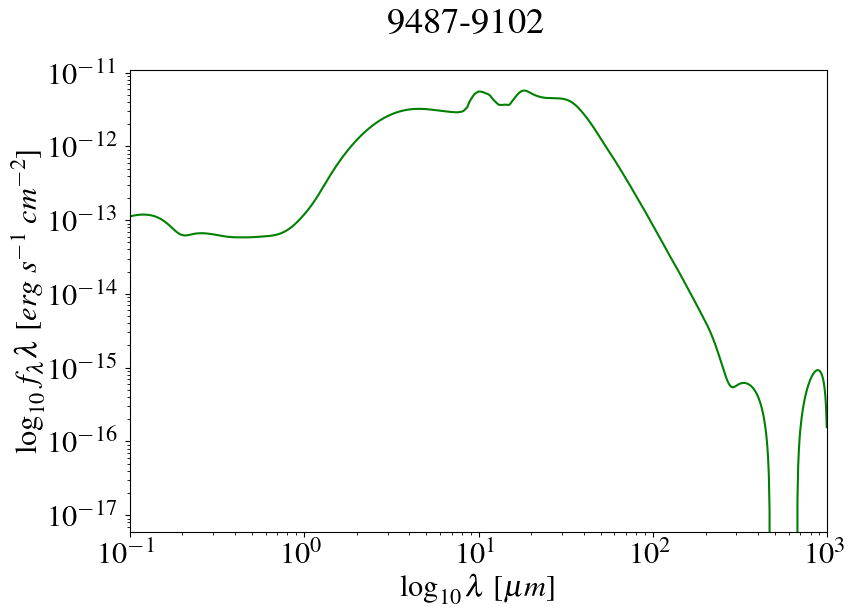

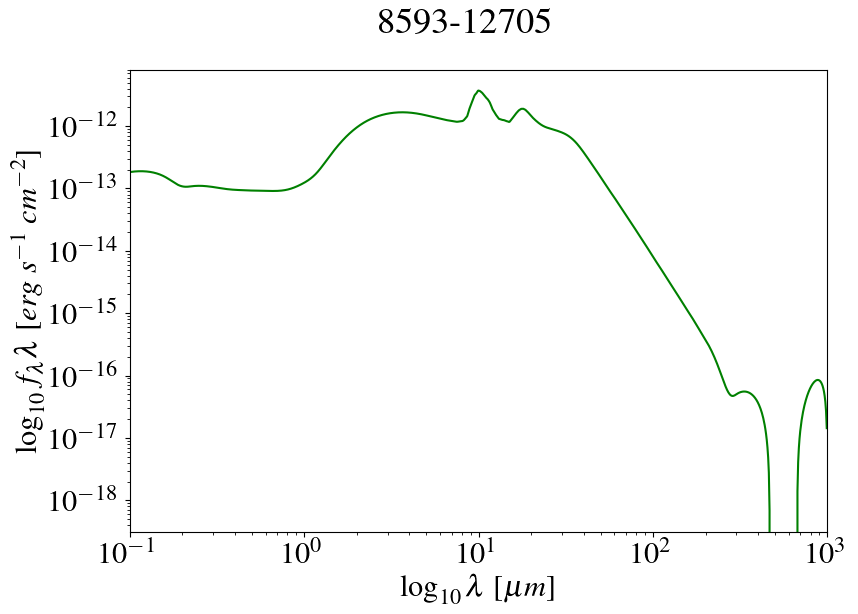

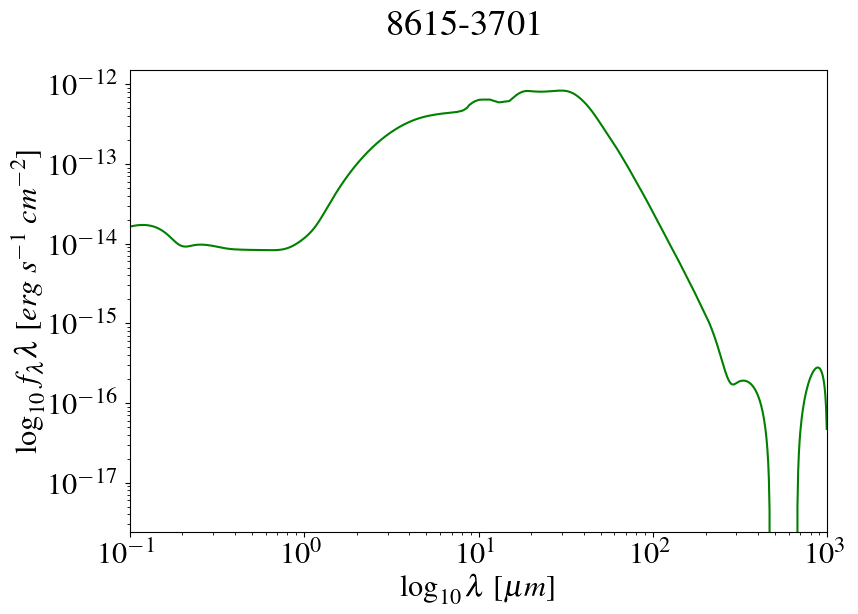

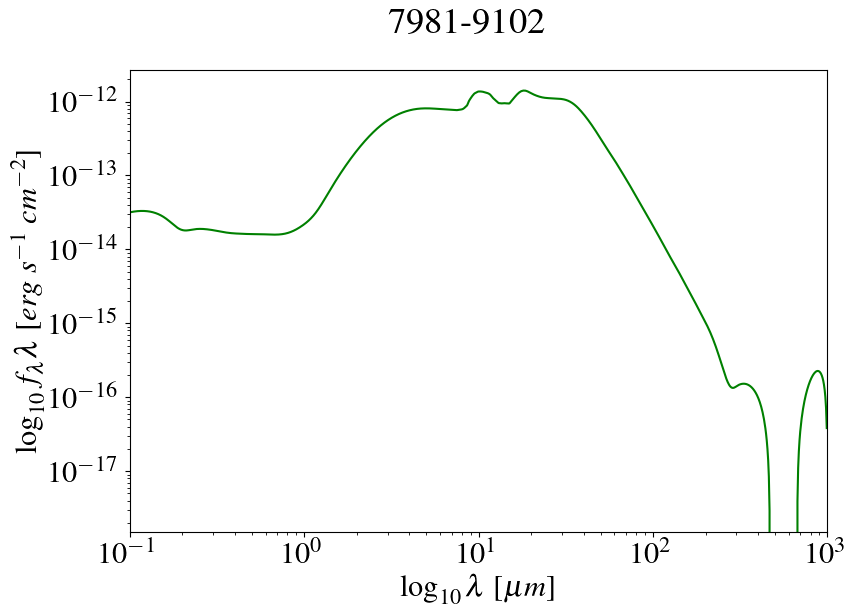

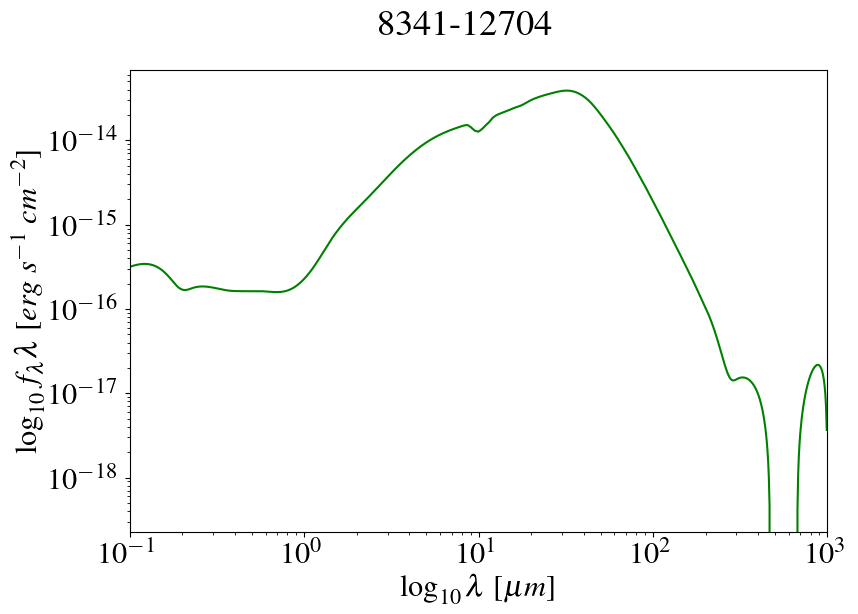

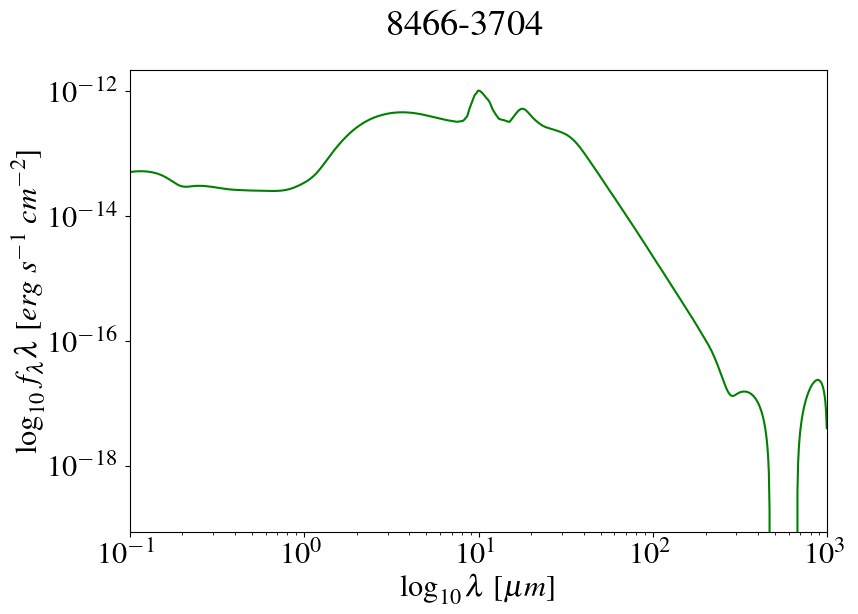

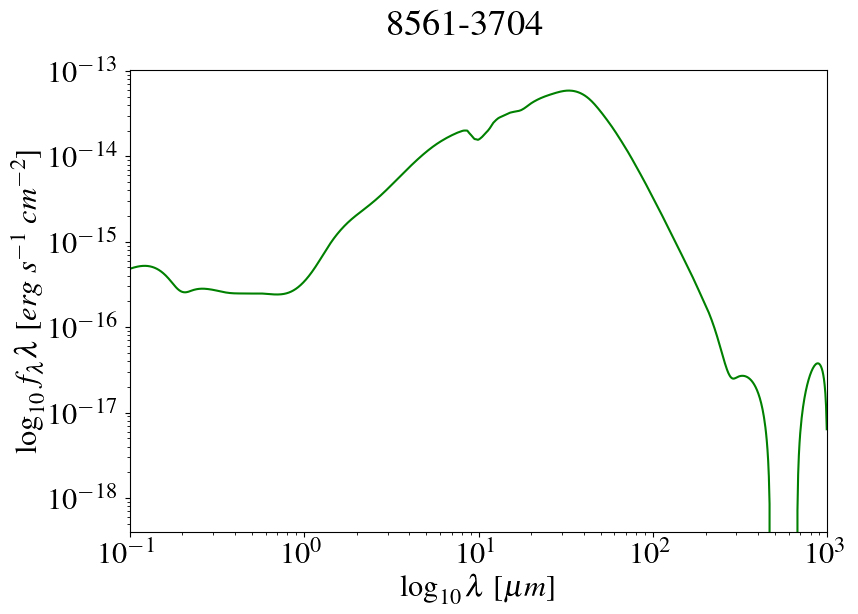

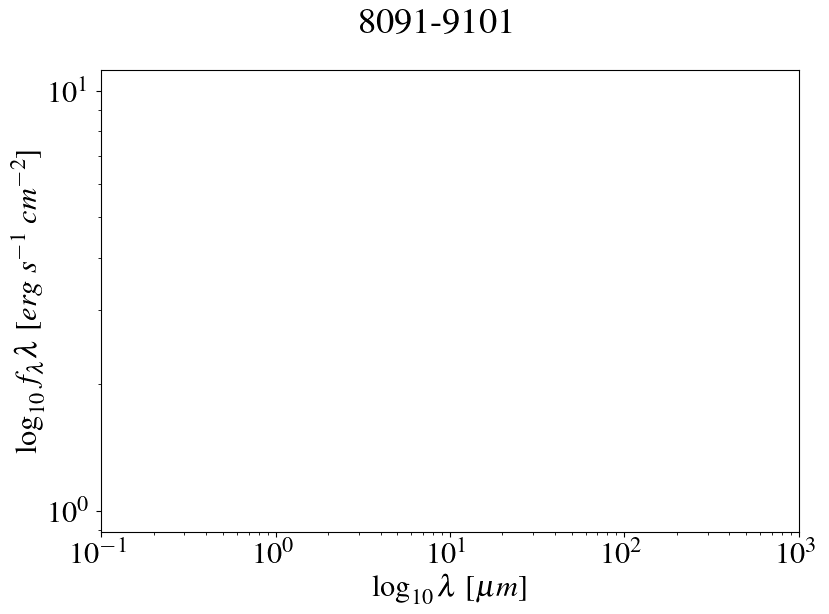

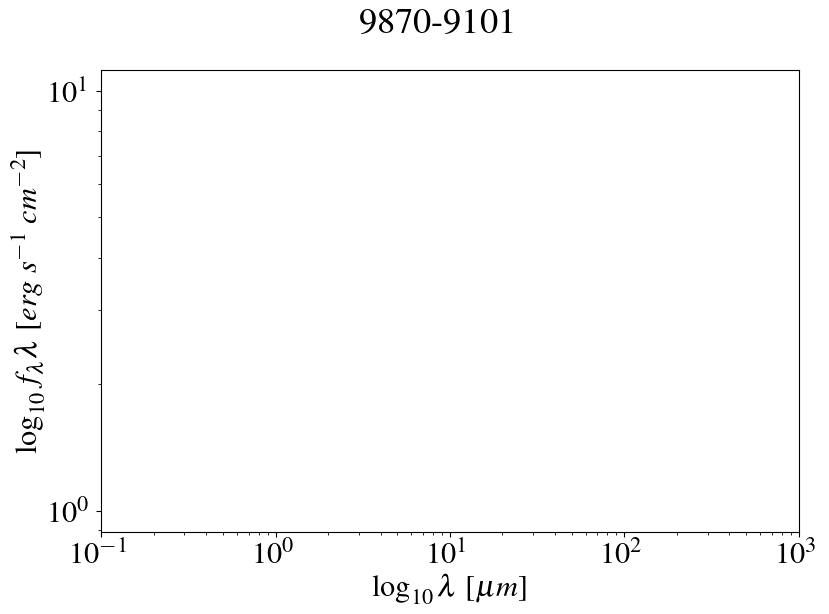

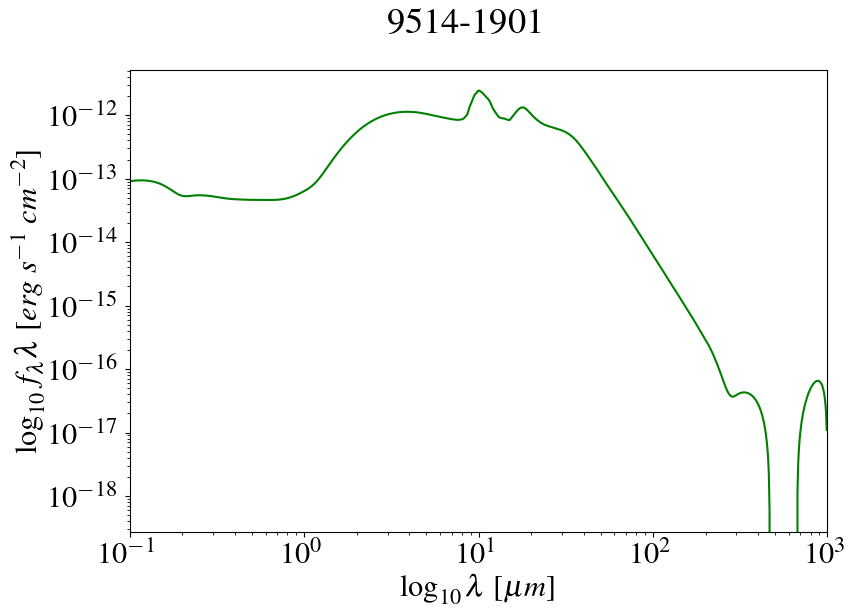

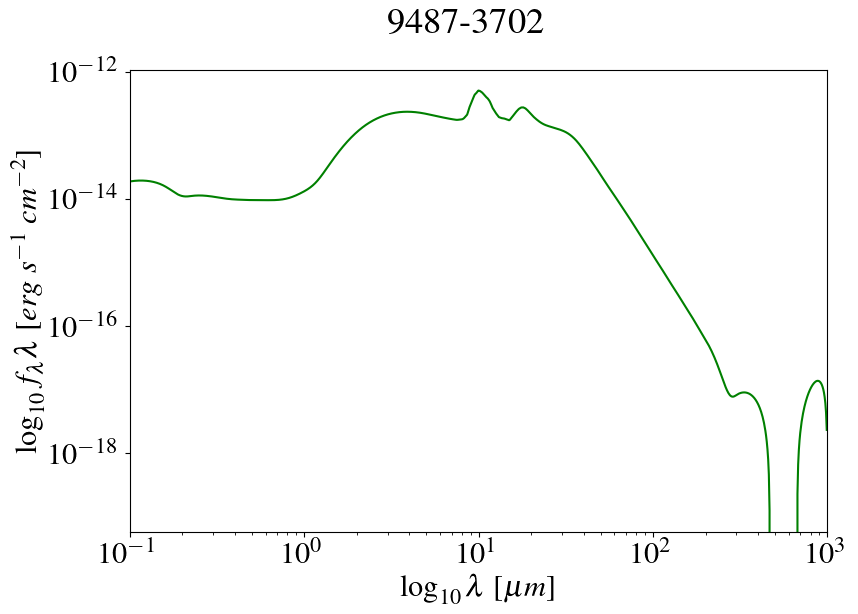

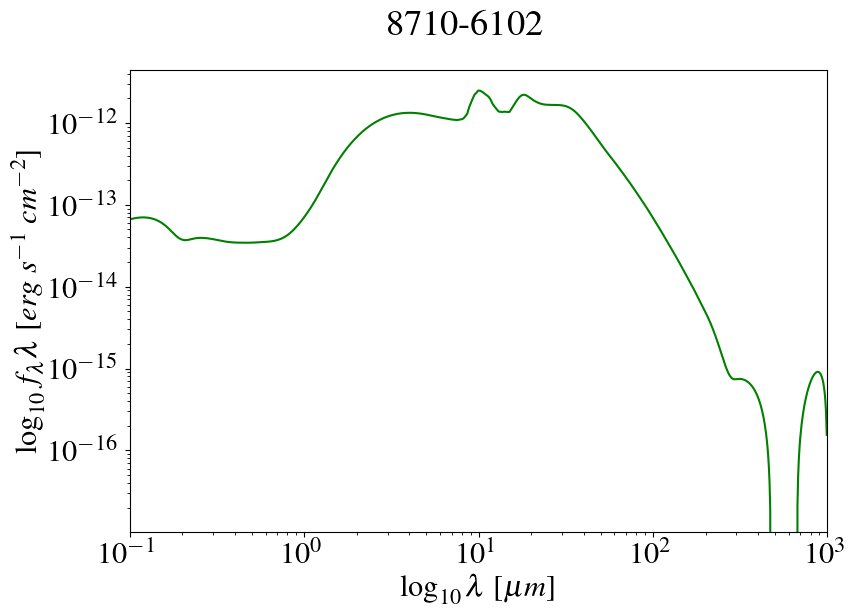

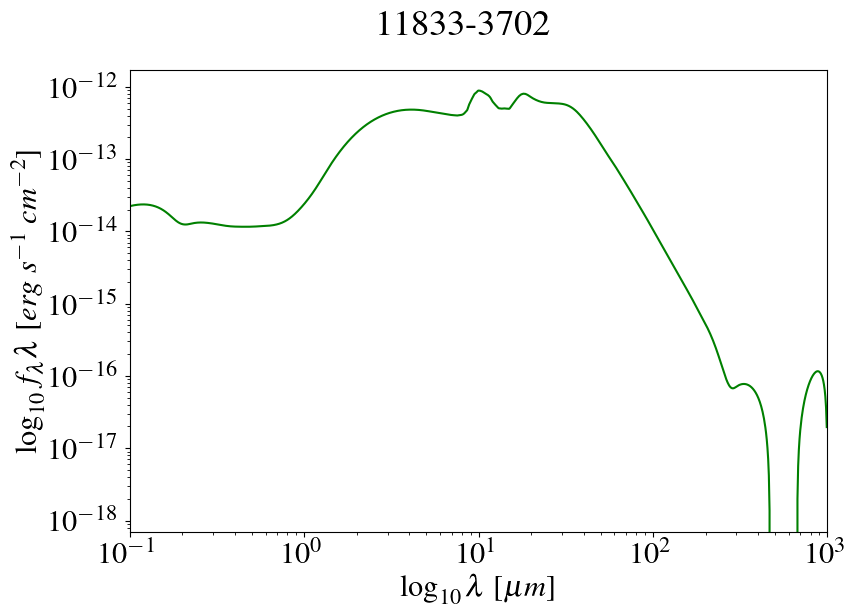

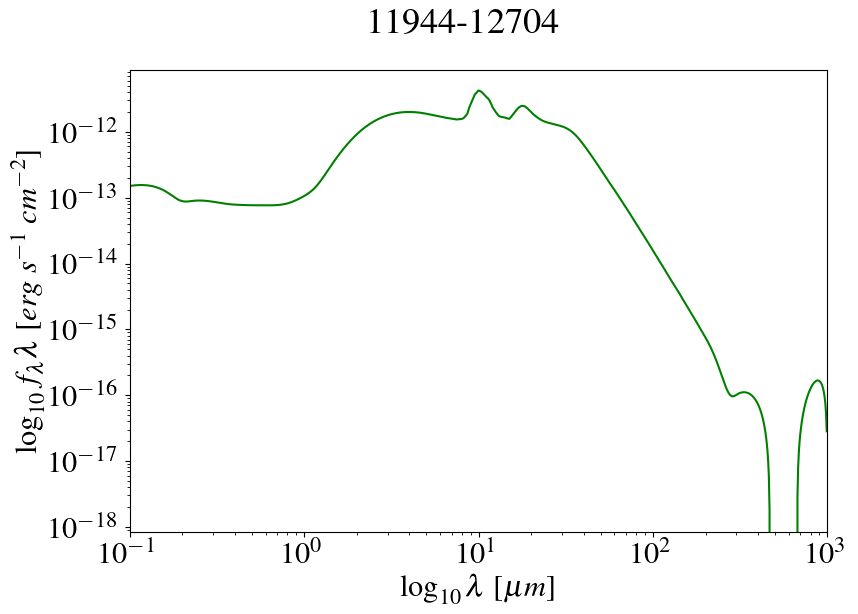

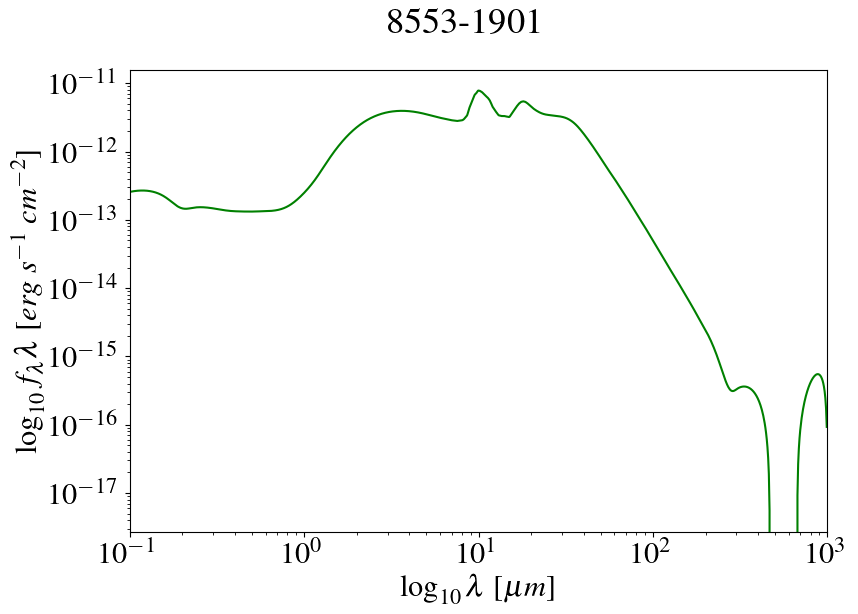

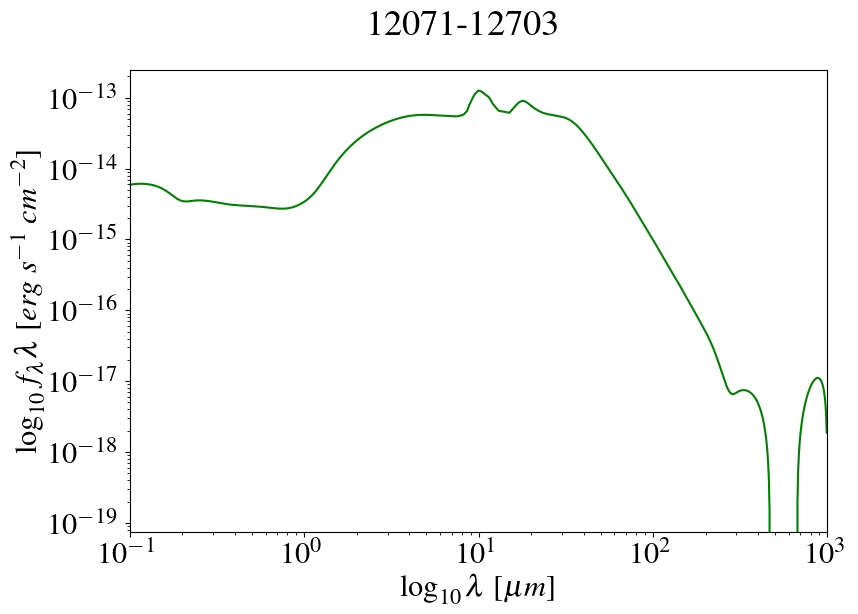

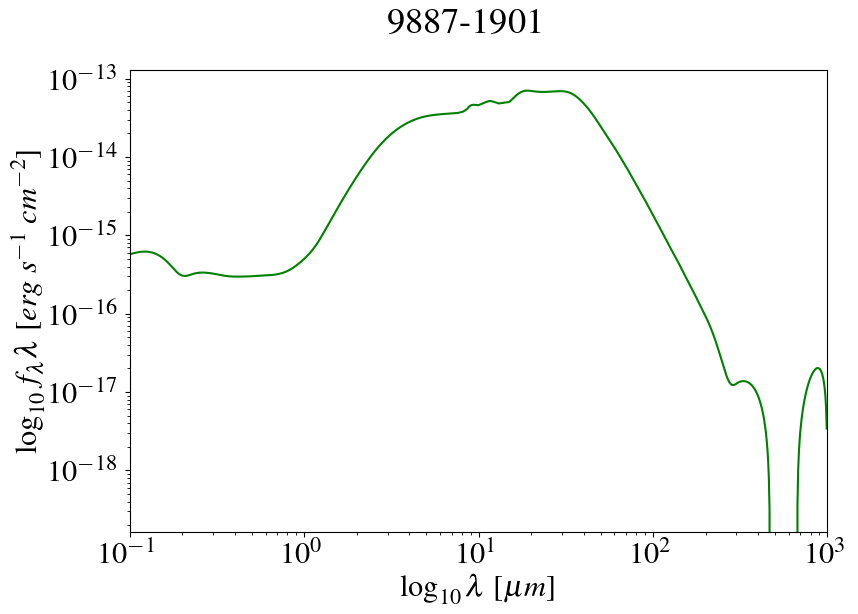

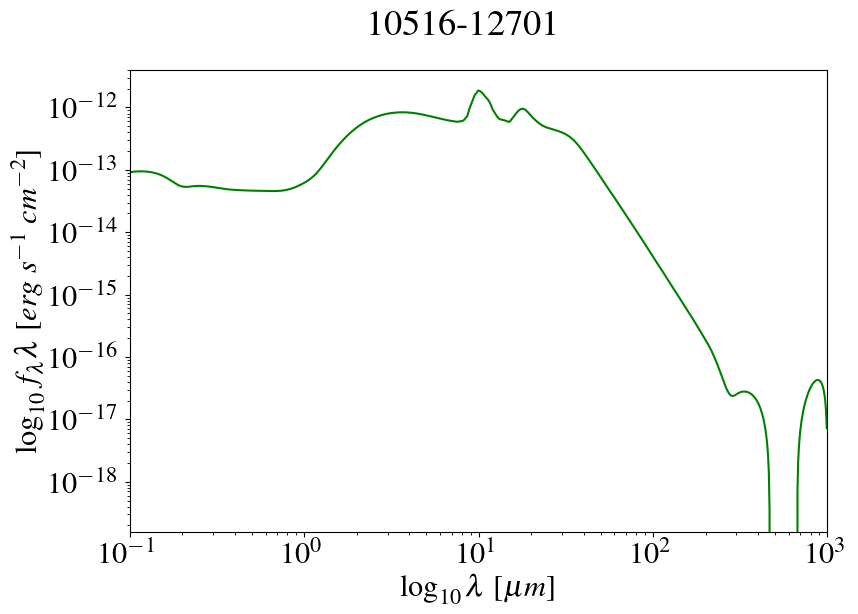

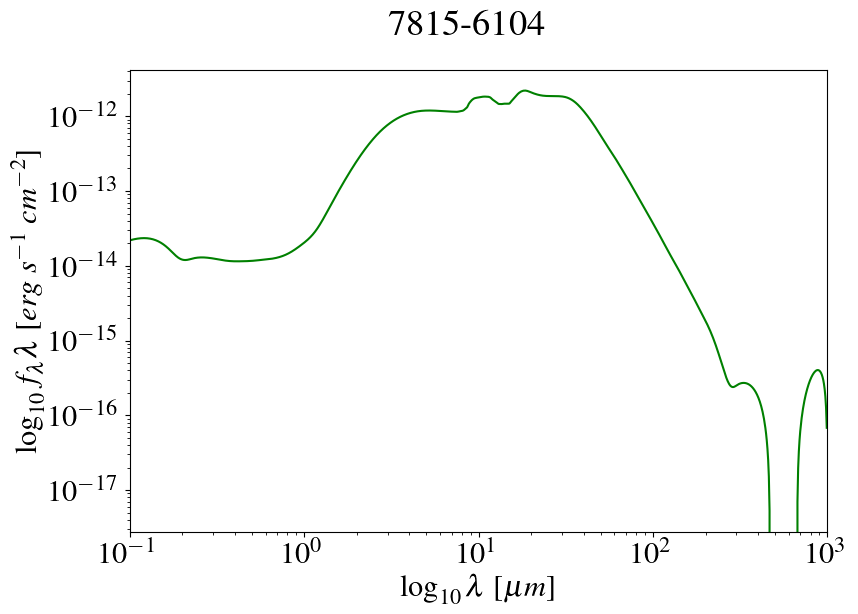

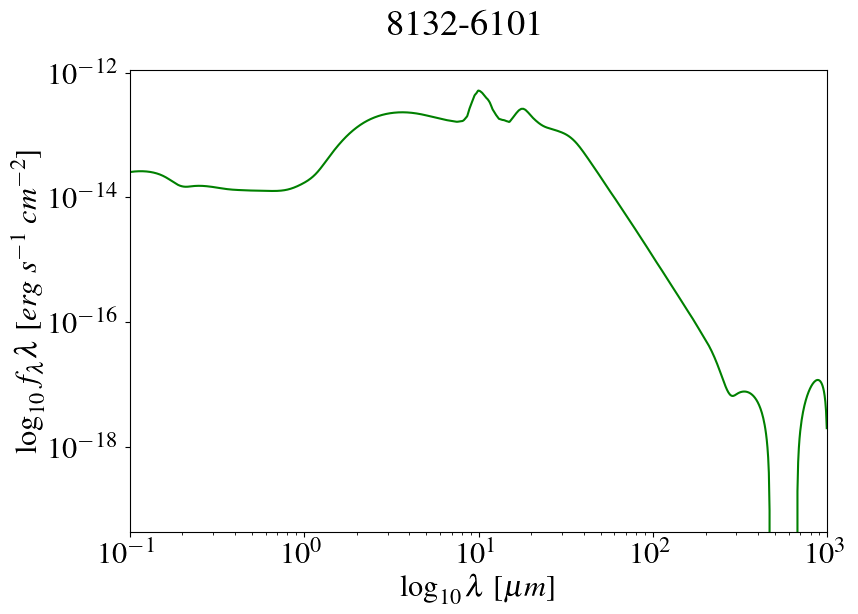

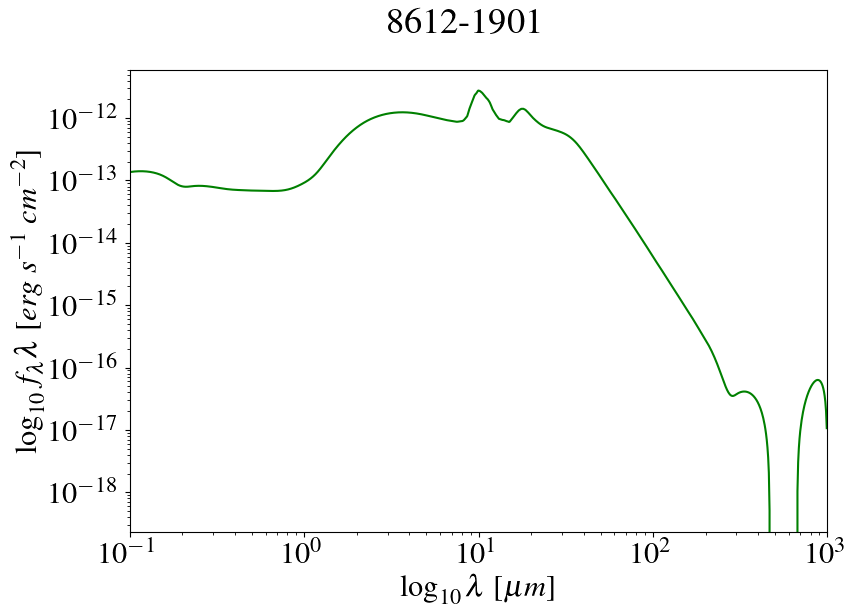

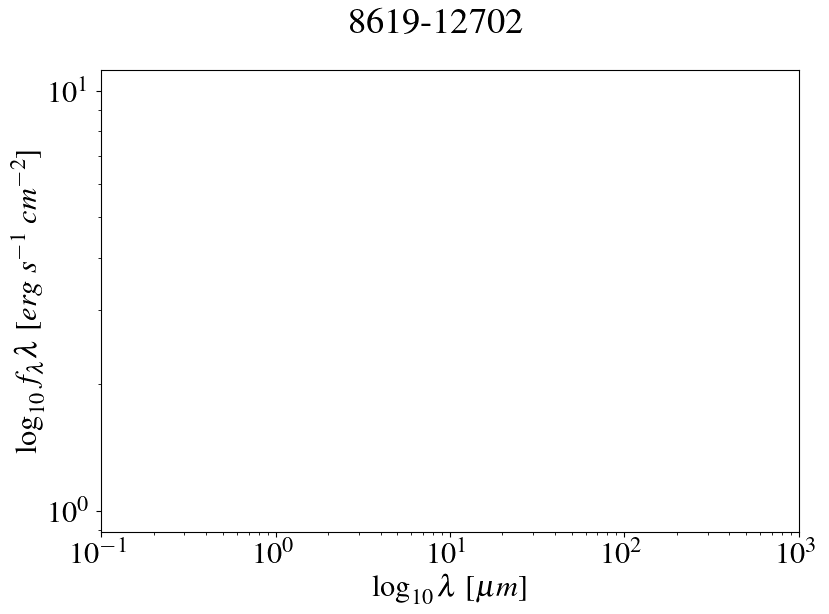

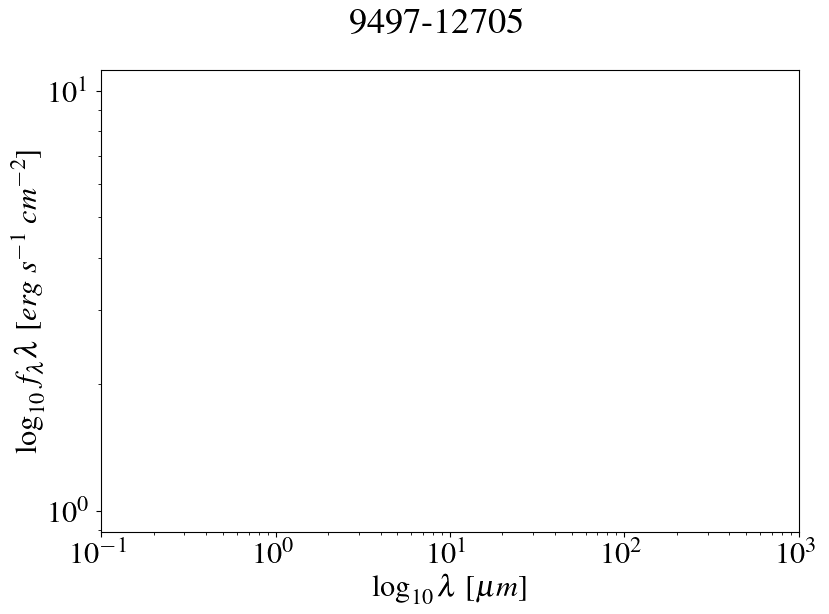

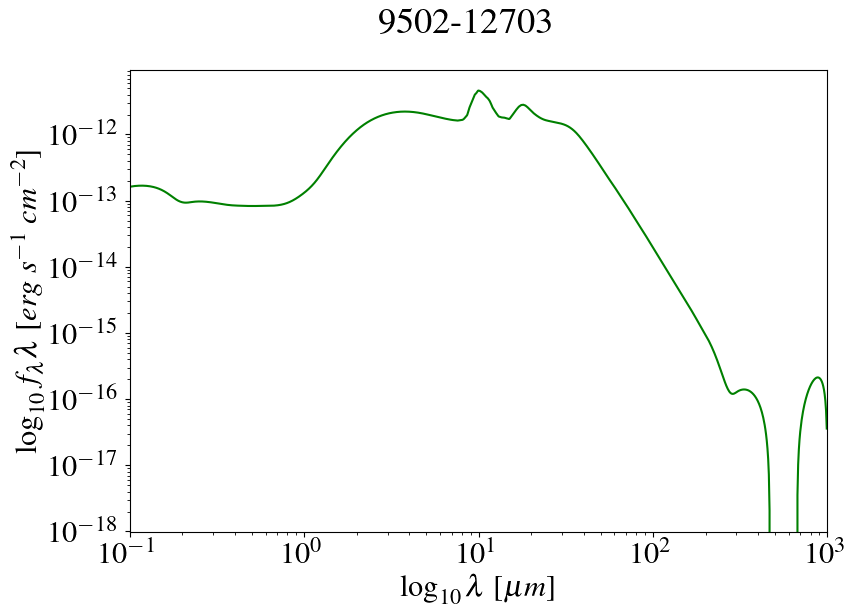

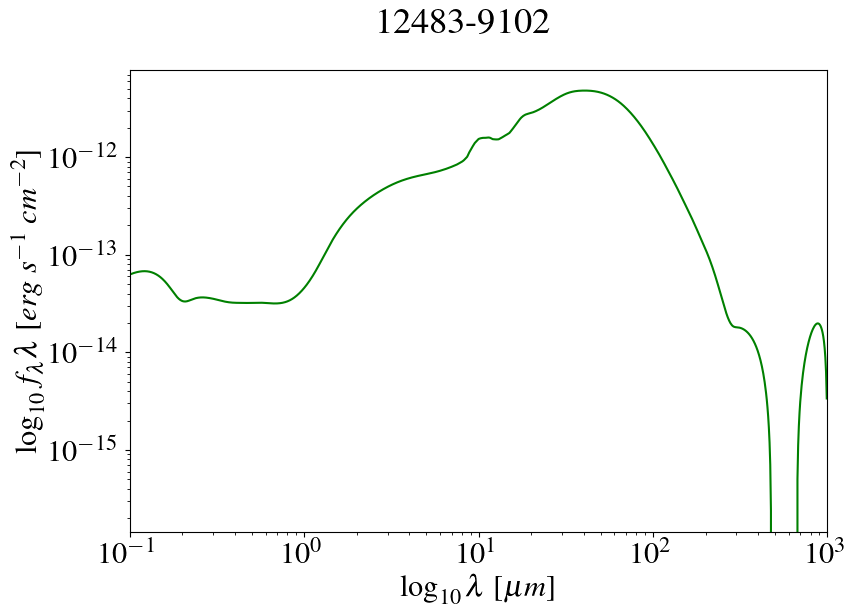

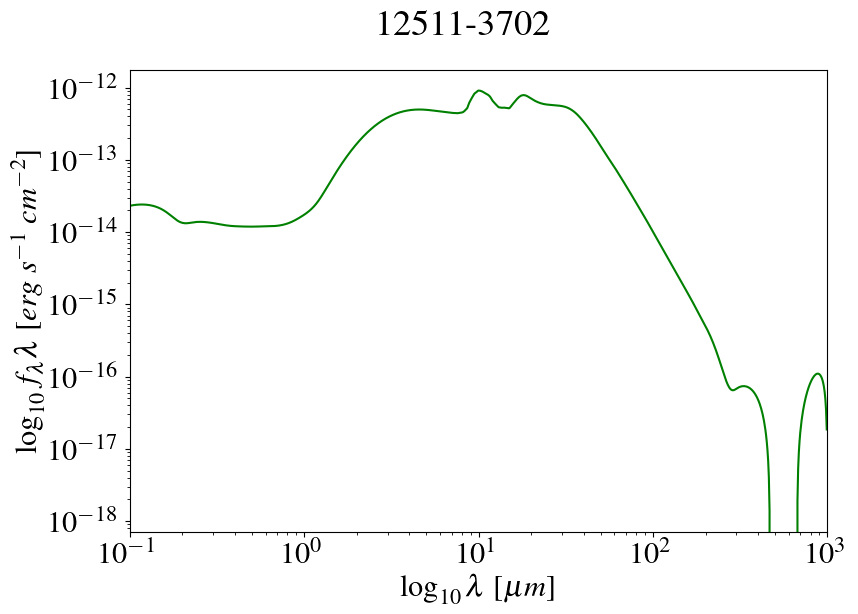

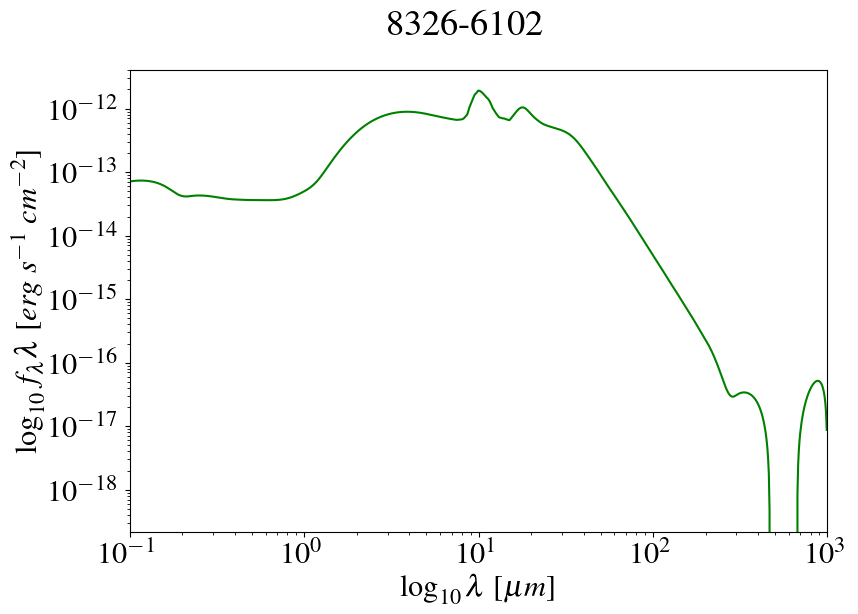

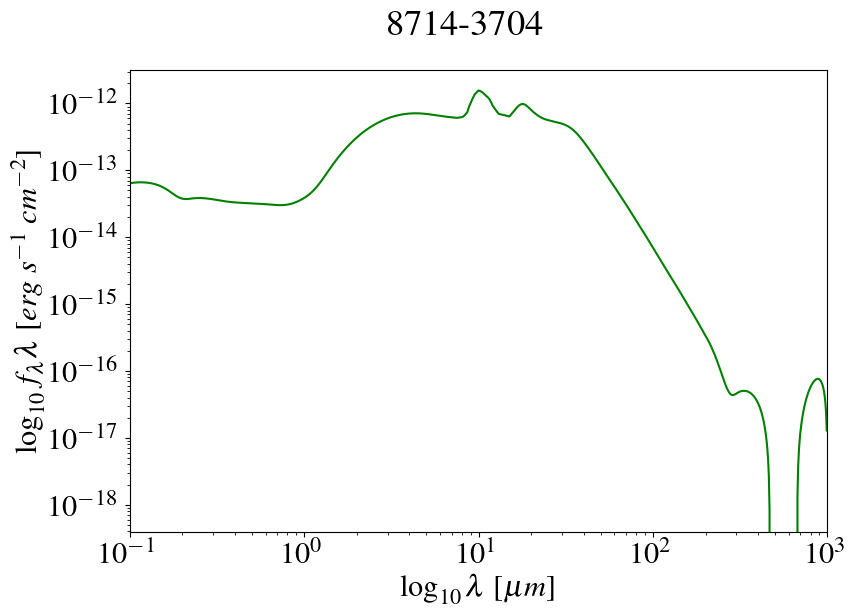

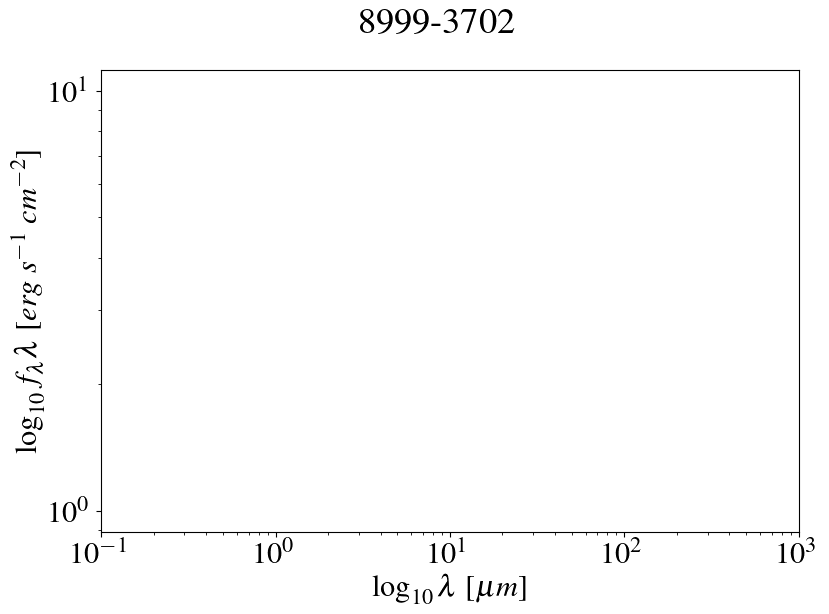

In [64]:
logL_AGN = np.array([])
logL = np.array([])
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Tcmb0=2.725 * u.K, Om0=0.3)
Lyu_L5100 = np.array([])
Lyu_L5100agn = np.array([])
for pifu in pifus:
    
    arr = mnsa_AP04['plateifu']
    index = np.where(arr == pifu)[0]
    wav = AP04_spec[0].data * u.Angstrom
    flux = AP04_spec[1].data[index] * u.erg / (u.s * u.cm**2 * u.Angstrom)
    agnflux = AP04_spec[2].data[index] * u.erg / (u.s * u.cm**2 * u.Angstrom)

    z = mnsa[mnsa['plateifu']==pifu]['redshift']

    ind1 = np.argmin(np.abs(wav.to(u.micron) - (0.1 * u.micron)))
    ind2 = np.argmin(np.abs(wav.to(u.micron) - (1000 * u.micron)))

    model = np.vstack((wav.to_value(u.micron)[ind1:ind2], flux[0].to_value(u.erg / (u.s * u.cm**2 * u.micron))[ind1:ind2]))
    agnmodel = np.vstack((wav.to_value(u.micron)[ind1:ind2], agnflux[0].to_value(u.erg / (u.s * u.cm**2 * u.micron))[ind1:ind2]))
    
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot((agnmodel[0]), (agnmodel[0]*agnmodel[1]), color='g', label='Total SED fit')
    fig.suptitle(pifu)
    ax.set_xlabel(r'$\log_{10}\lambda $ [$\mu m$]')
    ax.set_ylabel(r'$\log_{10}f_{\lambda}\lambda$ [$erg$ $s^{-1}$ $cm^{-2}$]')
    ax.set_xlim(0.1, 1000)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ind1 = np.argmin(np.abs(wav.to(u.micron) - (8 * u.micron)))
    ind2 = np.argmin(np.abs(wav.to(u.micron) - (1000 * u.micron)))

    model = np.vstack((wav[ind1:ind2].value, flux[0][ind1:ind2].value))
    agnmodel = np.vstack((wav[ind1:ind2].value, agnflux[0][ind1:ind2].value))

    Flambda_8_1000agn = np.trapz(y=agnmodel[1], x=agnmodel[0], dx=1e-6) * u.erg / (u.s * u.cm**2) 
    Flambda_8_1000 = np.trapz(y=model[1], x=model[0], dx=1e-6) * u.erg / (u.s * u.cm**2) 
    if z>0:
        L_IRagn = Flambda_8_1000agn * 4 * np.pi * (cosmo.luminosity_distance(z).to(u.cm))**2
        L5100agn = 0.47 * L_IRagn
        Lyu_L5100agn = np.append(Lyu_L5100agn, L5100agn.to_value(u.erg/u.s))
        L_IR =  Flambda_8_1000 * 4 * np.pi * (cosmo.luminosity_distance(z).to(u.cm))**2
        L5100 = 0.47 * L_IR
        Lyu_L5100 = np.append(Lyu_L5100, L5100.to_value(u.erg/u.s))
        #Lyu_5100_luminosity = np.append(Lyu_5100_luminosity, np.log10(L_IR.to_value(u.erg/u.s)/(4e33)))
        #print(L_IR)
        logL_AGN = np.append(logL_AGN, (4.89 + 0.91 * np.log10(L5100agn.to_value(u.erg/u.s))) - np.log10(4e33*1e11))
        logL = np.append(logL, (4.89 + 0.91 * np.log10(L5100.to_value(u.erg/u.s))) - np.log10(4e33*1e11))
    else:
        logL_AGN = np.append(logL_AGN, 0)

In [41]:
SPECTRA_FILEPATH ='C:/Users/paiaa/Documents/Research/Blanton Lab/WISE variations/Galaxy Cubes/sas/dr17/manga/spectro/redux/v3_1_1/'
#IMAGE_FILEPATH = os.path.join(os.path.curdir,'Galaxy Cubes/sas/dr17/manga/spectro/redux/v3_1_1/' )

manga_L5100 = np.array([])

for pifu in pifus:
    #split plateifu into plate and ifu
    p = pifu.split('-')

    #retrieve cube and image of galaxy
    cube = fits.open(SPECTRA_FILEPATH+ p[0] + '/stack/manga-' +p[0]+'-'+p[1]+'-LOGCUBE.fits.gz')

    j ,i = cube['FLUX'].shape[1]//2, cube['FLUX'].shape[2]//2
    wav = cube['WAVE'].data
    wav = SpectralCoord(wav * u.Angstrom, redshift=mnsa[mnsa['plateifu'] == pifu]['redshift']).to_rest()
    flux = cube['FLUX'].data * ( 1e-17 * u.erg/(u.s*u.cm**2*u.Angstrom)) 

    ind_5100 = np.argmin(np.abs(wav-(5100*u.Angstrom)))
    lambda_flambda = flux[:, j, i][ind_5100] * (5100*u.Angstrom)

    z = mnsa[mnsa['plateifu'] == pifu]['redshift']
    L_5100 =  lambda_flambda * 4 * np.pi * (cosmo.luminosity_distance(z).to(u.cm))**2

    manga_L5100 = np.append(manga_L5100, L_5100.to_value(u.erg/u.s))

Text(0, 0.5, '$\\log_{10}{L_{5100}/(10^{11}L_\\odot)}$ (Lyu+2019)')

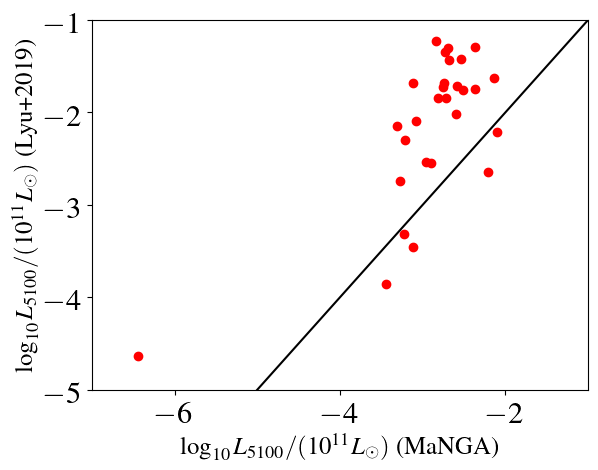

In [68]:
x = np.linspace(-7, 1)
plt.scatter(np.log10(manga_L5100/(4e33*1e11)), np.log10(Lyu_L5100agn/(4e33*1e11)), c='r')
plt.plot(x, x, c='k')

plt.ylim(-5, -1)
plt.xlim(-7, -1)

plt.xlabel(r'$\log_{10}{L_{5100}/(10^{11}L_\odot)}$ (MaNGA)', fontsize=18)
plt.ylabel(r'$\log_{10}{L_{5100}/(10^{11}L_\odot)}$ (Lyu+2019)', fontsize=18)

In [63]:
np.mean(np.log10(Lyu_L5100agn/(4e33*1e11))[np.isfinite(np.log10(Lyu_L5100agn/(4e33*1e11)))]), np.mean(np.log10(manga_L5100/(4e33*1e11)))

(-2.1492807870503836, -2.8521690028896636)

In [67]:
np.median(np.log10(Lyu_L5100agn/(4e33*1e11))[np.isfinite(np.log10(Lyu_L5100agn/(4e33*1e11)))]), np.median(np.log10(manga_L5100/(4e33*1e11)))

(-1.8415381885468105, -2.7523311796532015)

In [20]:

Lyu2019 = Table.read(IMPORT_FILEPATH+'/Data/Timelags/Lyu2019.txt', format='ascii.no_header', delimiter='\t')
LyuW1 = Table()
LyuW1['L'] = np.log10(10**Lyu2019['col4'][Lyu2019['col13']==1]/1e11)
LyuW2 = Table()
LyuW2['L'] = np.log10(10**Lyu2019['col4'][Lyu2019['col14']==1]/1e11)

w1, w1_err = np.array([]), np.array([])
for i, val in enumerate(Lyu2019['col7']):
    if Lyu2019['col13'][i] == 1:
        obs = val.split(' +or- ')
        w1 = np.append(w1, float(obs[0]))
        w1_err = np.append(w1_err, float(obs[1]))

w2, w2_err = np.array([]), np.array([])
for i, val in enumerate(Lyu2019['col10']):
    if Lyu2019['col14'][i] == 1:
        obs = val.split(' +or- ')
        w2 = np.append(w2, float(obs[0]))
        w2_err = np.append(w2_err, float(obs[1]))

LyuW1['w1'] = w1
LyuW1['w1_err'] = w1_err

LyuW2['w2'] = w2
LyuW2['w2_err'] = w2_err

In [21]:
Koshida2014 = Table.read(IMPORT_FILEPATH+'/Data/Timelags/Koshida2014_inLyu2020.txt', format='ascii.no_header', delimiter='\t')

KoshidaW1 = Table()
KoshidaW1['L'] = np.log10(10**Koshida2014['col3']/1e11)

w1 = np.array([])
for val in Koshida2014['col5']:
    w1=np.append(w1, val)
KoshidaW1['w1'] = w1

#WA CCF time lag with alpha = 1/3
w1_kosh = np.array([132.1, 35.9, 92.0, 127.6, 86.4, 67.0, 84.3, 13.3, 47.3, 19.2, 14.3, 43.1, 44.0, 53.0, 83.5, 133.4, 48.6])
#JAVELIN with alpha = 1/3
#w1_kosh = np.array([165.8, 32.2, 152.5, 129.7, 69.9, 71.8, 106.8, 13.8, 71.5, 19.7, 15.8, 40.9, 42.1, 61.3, 89.8, 120.3,78.12])
#CCF with alpha = 0
#w1_kosh = np.array([142.2, 37.2, 108.2, 138.8, 95.8, 74, 90.3, 14.5, 52.9, 20.4, 14.7, 49.7, 43.5, 55.2, 89.8, 149.2, 48.3])
w1_kosh_err = np.array([15.8, 2.7, 4.5, 15.2, 12.7, 2.6, 5.8, 0.6, 9.9, 1.9, 0.4, 0.8, 2.0, 0.6, 7.6, 8.8, 1.8])

KoshidaW1['w1_kosh'] = w1_kosh
KoshidaW1['w1_kosh_err'] = w1_kosh_err

In [22]:
Yang2020 = open(IMPORT_FILEPATH+'/Data/Timelags/Yang2020.txt',  'r')

YangW1 = Table(names=['ID', 'ra', 'dec', 'z', 'logL', 'err_logL', 'logBH', 'err_logBH', 'Ratio', 'Num', 'w1', 'w1rms', 'err_w1rms', 'w1snr', 'rmax', 'rwmax', 'peak', 'fpeak', 'lag', 'errmin_lag', 'errmax_lag'])

for i, line in enumerate(Yang2020):
    row = line.split()
    YangW1.add_row(row)

YangW1['logL'] -= (np.log10(1e11*4e33))

In [23]:
ind =~((tab['lag_w1'] < 0.01) | (tab['lag_w2'] < 0.01)) & (np.isfinite(logL_AGN))
(logL_AGN[ind]).shape

(24,)

In [32]:
logL_AGN, logL[~np.isfinite(logL_AGN)], np.isfinite(logL_AGN)

(array([-0.31452116, -1.08086081,        -inf, -0.65268046, -0.65828069,
        -0.43324655, -0.80040837, -0.79956193, -0.30345216, -2.63983536,
        -0.60454847, -2.1407535 ,        -inf,        -inf, -0.69923979,
        -1.43647075, -1.22015041, -1.44193888, -0.34631087, -0.72153478,
        -2.26586673, -1.53529809, -1.61942098, -0.24219326, -0.71509691,
        -1.13944335,        -inf,        -inf, -1.02549911, -3.34256928,
        -0.4208233 , -0.68378071, -0.95707897,        -inf]),
 array([-0.22346946, -1.01059975, -0.63981711,  1.01177506,        -inf,
         0.08717493]),
 array([ True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True,  True,  True,  True, False]))

In [29]:
w1_errmax, w1_errmin = tab['lag_w1_yerr_max'], tab['lag_w1_yerr_min']
w2_errmax, w2_errmin = tab['lag_w2_yerr_max'], tab['lag_w2_yerr_min']

Text(0.5, 0, '$L_{\\mathrm{AGN}} (10^{11}L_{\\odot})$')

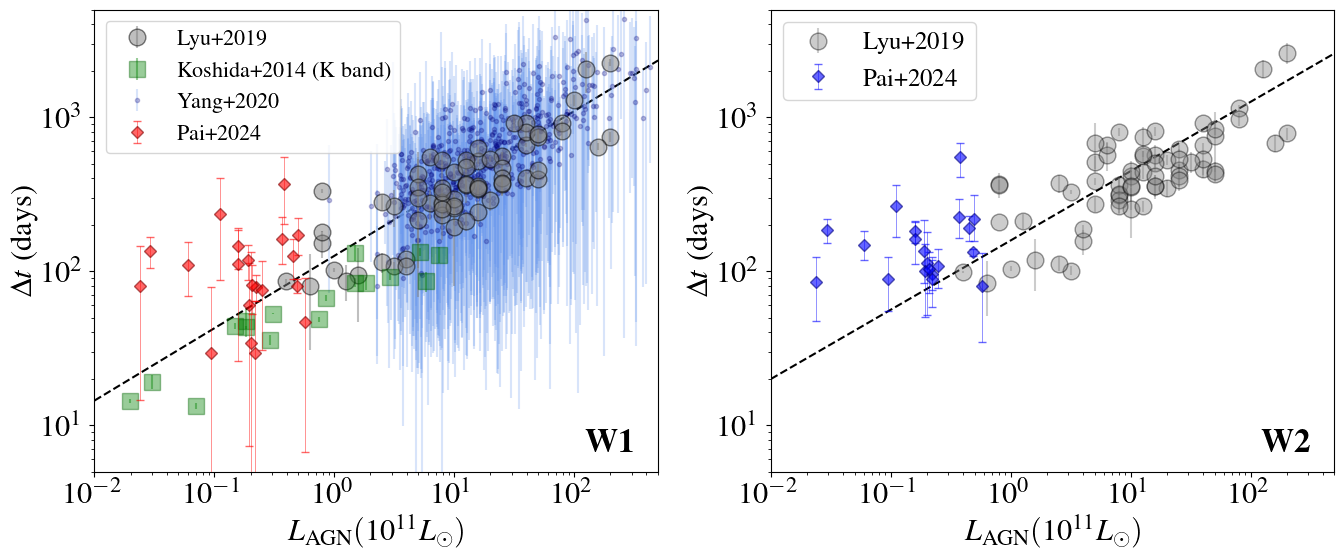

In [70]:

x = np.linspace(1e-2, 5e2)
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[0].errorbar(10**LyuW1['L'], LyuW1['w1'], yerr=LyuW1['w1_err'], ls='none', marker='o', ms=12, c='grey', mec='k', alpha=0.5, label='Lyu+2019')
ax[0].errorbar(10**KoshidaW1['L'], KoshidaW1['w1_kosh'], yerr=KoshidaW1['w1_kosh_err'], ls='none', marker='s', ms=12, c='green', mec='darkgreen', alpha=0.4, label='Koshida+2014 (K band)')
ax[0].errorbar(10**YangW1['logL'], YangW1['lag'], yerr=(YangW1['errmin_lag'], YangW1['errmax_lag']), ls='none', marker='.', ms=6, c='cornflowerblue', mfc='navy', mec='navy', alpha=0.25, zorder=-1, label='Yang+2020')
ax[0].errorbar(10**logL_AGN[ind], tab['lag_w1'][ind], yerr=(w1_errmin[ind], w1_errmax[ind]), elinewidth=0.5, ls='none', capsize=3, markeredgecolor='maroon', c='red', alpha=0.6,  marker='D',ms=6, zorder=9, label='Pai+2024')
#ax[0].errorbar(10**logL_AGN[ind], tab['lag_w1'][ind], yerr=(w1_errmin[ind], w1_errmax[ind]), elinewidth=0.5, ls='none', capsize=3, markeredgecolor='maroon', c='red', markerfacecolor=(0, 0, 0, 0), marker='D',ms=6, zorder=9)
#ax[0].errorbar(10**logL[~np.isfinite(logL_AGN)], tab['lag_w1'][~np.isfinite(logL_AGN)], yerr=(w1_errmin[~np.isfinite(logL_AGN)], w1_errmax[~np.isfinite(logL_AGN)]), elinewidth=0.5, ls='none', capsize=3, markeredgecolor='maroon', c='red', alpha=0.6, marker='D',ms=6, zorder=10, label='Pai+2024')

ax[0].plot(x, 10**2.1*x**0.47, c='k', ls='dashed', zorder=-2)

# ax[0].plot(x, 10**2.7*x**0.47, c='grey', ls='dashed', zorder=-2)
# ax[0].plot(x, 10**1.6*x**0.47, c='grey', ls='dashed', zorder=-2)
#ax[0].plot(x, 10**fit_w1[1]*x**fit_w1[0], c='k', ls='dashed', zorder=-2)
ax[0].text(0.87, 0.03, r'\textbf{W1}', fontsize=24, ha='left', va='bottom', transform=ax[0].transAxes)

ax[0].legend(fontsize=16)

ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[0].set_ylim(5, 5e3)
ax[0].set_xlim(1e-2, 5e2)

ax[0].set_ylabel(r'$\Delta t$ (days)')
ax[0].set_xlabel(r'$L_{\mathrm{AGN}} (10^{11}L_{\odot})$')

ax[1].sharex(ax[0])
ax[1].sharey(ax[0])

ax[1].errorbar(10**LyuW2['L'], LyuW2['w2'], yerr=LyuW2['w2_err'], ls='none', marker='o', ms=12, c='grey', mec='k', alpha=0.4, label='Lyu+2019')
ax[1].errorbar(10**(logL_AGN[ind]), (tab['lag_w2'][ind]),yerr=((w2_errmin[ind]),(w2_errmax[ind])), elinewidth=0.5, ls='none', capsize=3, markeredgecolor='navy', c='blue', alpha=0.6, marker='D', ms=6, zorder=10, label='Pai+2024')
# ax[1].errorbar(10**logL_AGN[ind], tab['lag_w2'][ind], yerr=(w2_errmin[ind], w2_errmax[ind]), elinewidth=0.5, ls='none', capsize=3, markeredgecolor='navy', c='navy', markerfacecolor=(0, 0, 0, 0), marker='D',ms=6, zorder=9)
# ax[1].errorbar(10**logL_AGN[flags], tab['lag_w2'][flags], yerr=(w2_errmin[flags], w2_errmax[flags]), elinewidth=0.5, ls='none', capsize=3, markeredgecolor='navy', c='blue', alpha=0.6, marker='D',ms=6, zorder=10, label='Pai+2024')

ax[1].plot(x, 10**2.2*x**0.45, c='k', ls='dashed', zorder=-2)
ax[1].text(0.87, 0.03, r'\textbf{W2}', fontsize=24, ha='left', va='bottom', transform=ax[1].transAxes)

ax[1].legend(fontsize=18)

ax[1].set_yscale('log')
ax[1].set_xscale('log')

ax[1].set_ylabel(r'$\Delta t$ (days)')
ax[1].set_xlabel(r'$L_{\mathrm{AGN}} (10^{11}L_{\odot})$')

# ax[1].set_ylim(1e1, 5e3)
# ax[1].set_xlim(1e-2, 5e2)

In [100]:
tab

plateifu,lag_w1,amp_w1,const_w1,lag_w2,amp_w2,const_w2,lag_w1_yerr_min,lag_w1_yerr_max,lag_w2_yerr_min,lag_w2_yerr_max
str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10223-3701,80.353284,5.612946823934482,13.490747035946677,132.9481608,7.204759294518239,13.634898991196257,7.820984700183217,8.539209479480029,6.6540652661227355,6.875982479031565
9000-1901,0.0,1.9013507868307096,13.965150492470839,33.6022824,2.020823057755979,13.888883889184887,12.42337868294742,11.848252839848238,13.179979751705051,13.392403295614386
7977-9101,17.5316256,1.1953787278363595,14.231139129001791,84.73619040000001,1.5587900515557804,14.51728632378981,22.049831569611438,24.499588479241716,27.7951167439588,25.194908542651632
9186-9101,78.8923152,0.7857959464340765,13.411106361140826,96.42394080000001,0.7037030357706712,13.380107005455354,14.605478302496191,15.524517152911516,20.374706503818874,26.437188476454846
8091-6101,29.219376000000004,0.9668701176090825,14.02215346910758,88.3886124,1.2605725153640093,14.097740414633677,34.82380269568833,34.95731420024324,30.17515914409339,29.84247415278162
9487-9102,161.43705240000065,1.1504476292087815,13.771862765687944,224.2587108000006,1.180605111463866,13.763480829910447,49.265617691802994,62.76516870242452,59.15643842550163,70.3789154987285
8593-12705,145.3663956,0.9552630891557333,14.006631088770195,183.3515844,1.284215569129718,14.227314138700857,41.473377428592464,39.77361412755918,30.173777925482305,29.50660259654191
8615-3701,111.0336288,1.1441048144860733,15.141466967389867,160.706568,1.955234974439713,15.33119440293353,84.79665259435464,80.81205537803606,49.793920215317954,48.600278659961816
7981-9102,172.39431840000003,0.6698613096780281,14.837823204584272,219.87580440000002,0.5345764735875086,14.766370015743334,44.03920278840051,49.77705891206396,63.27071425415675,93.62918177140192


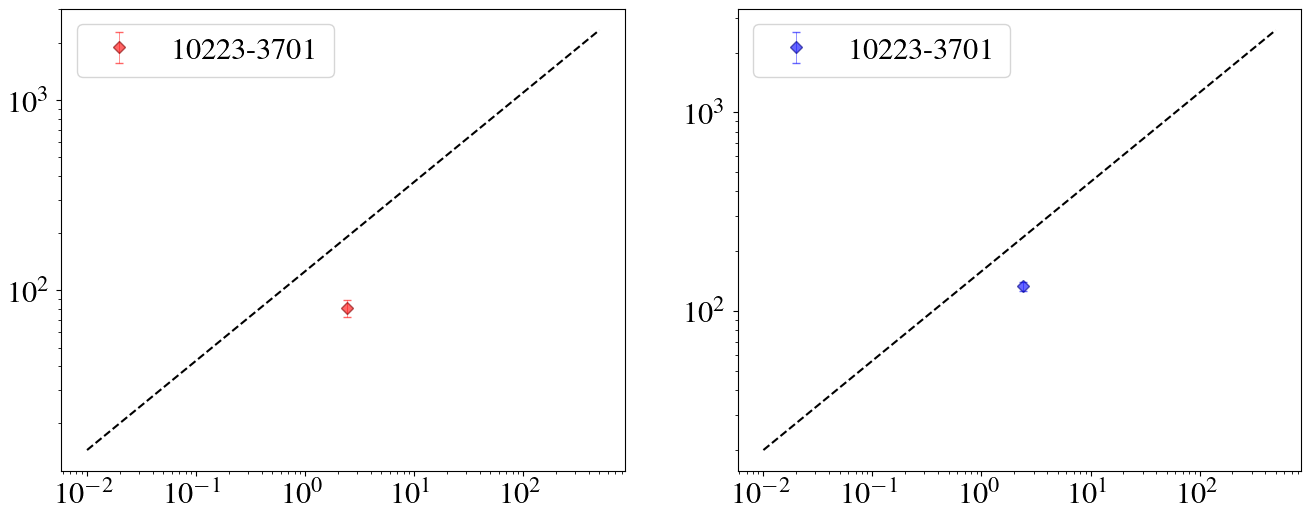

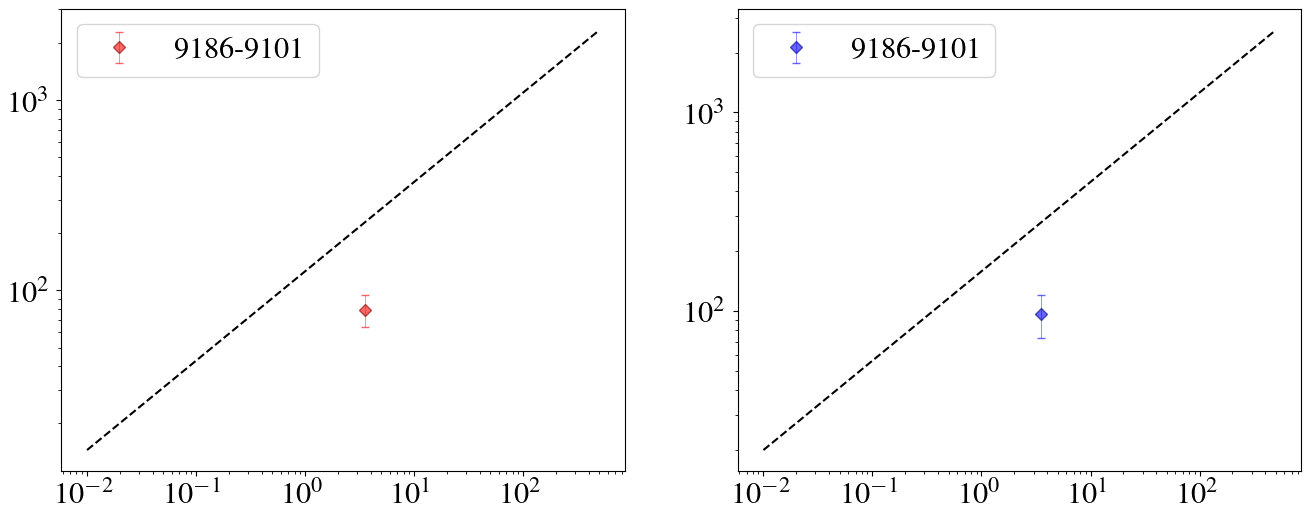

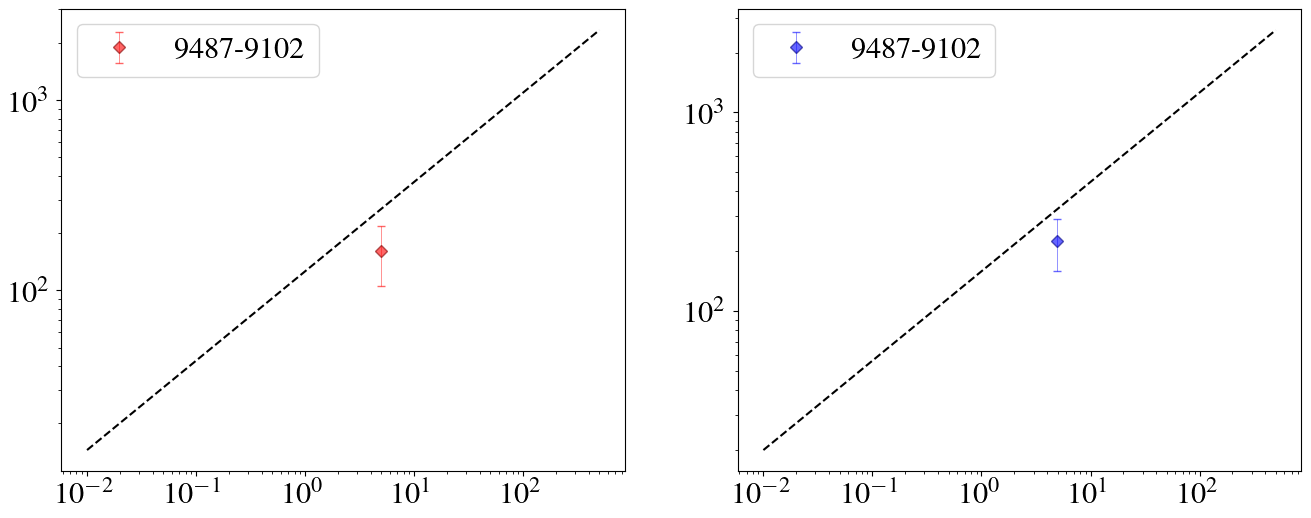

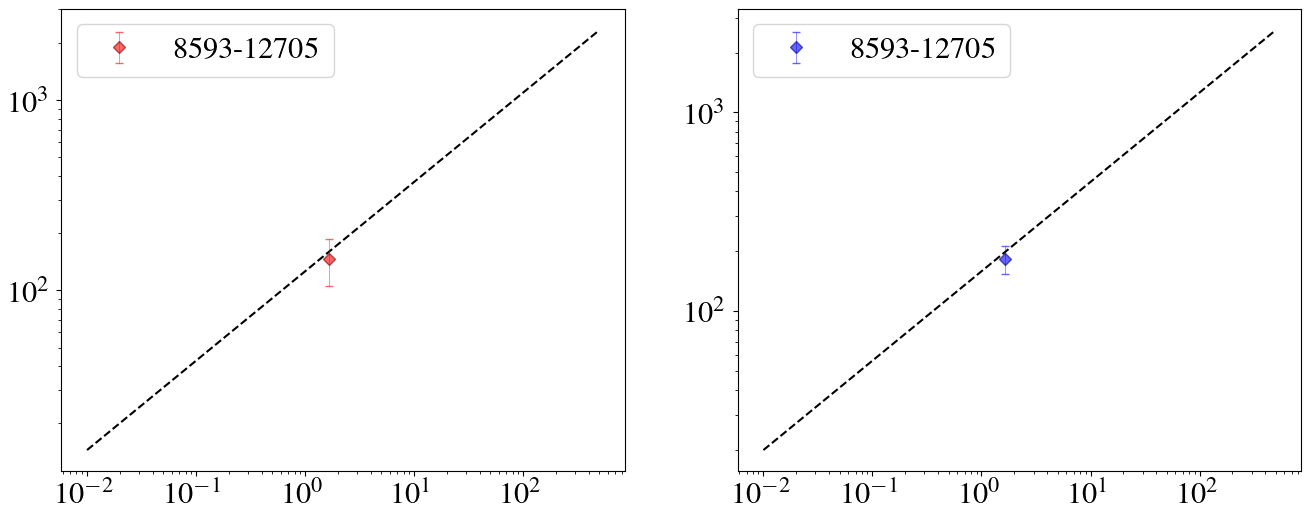

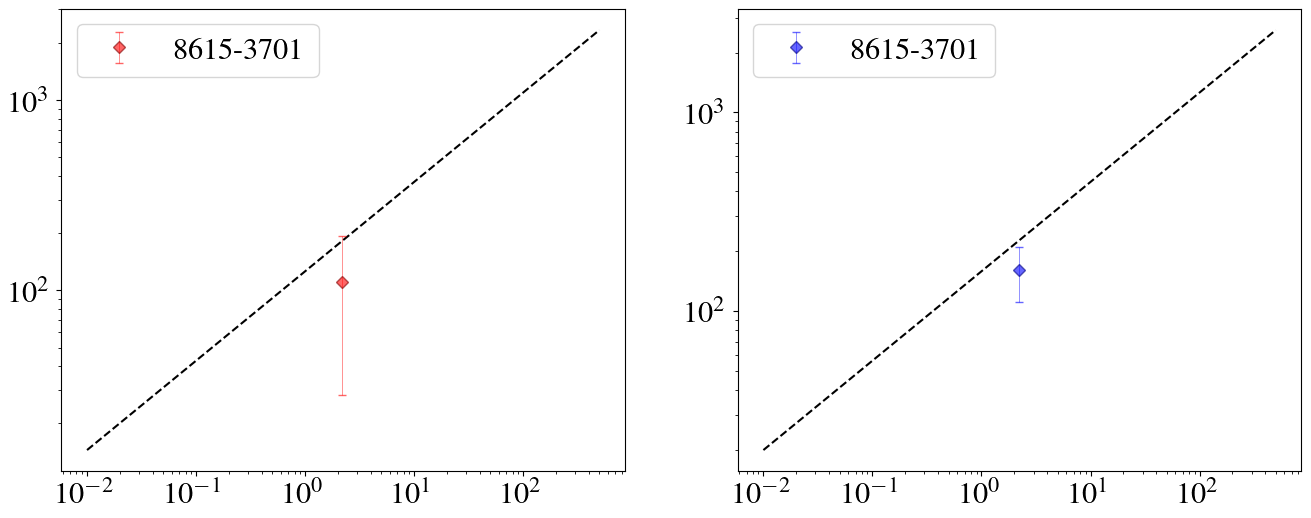

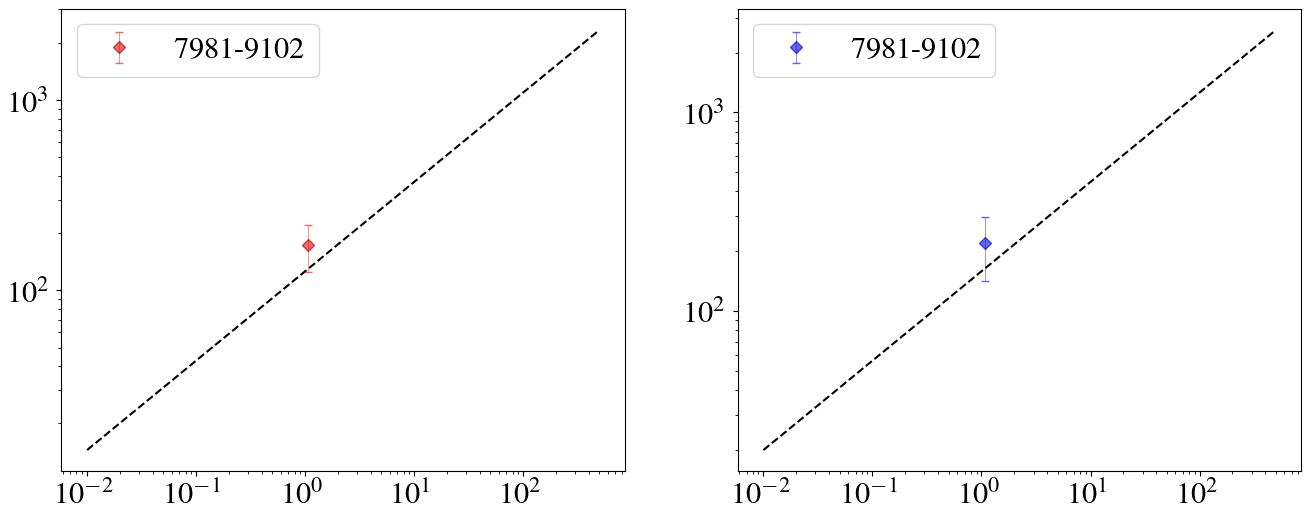

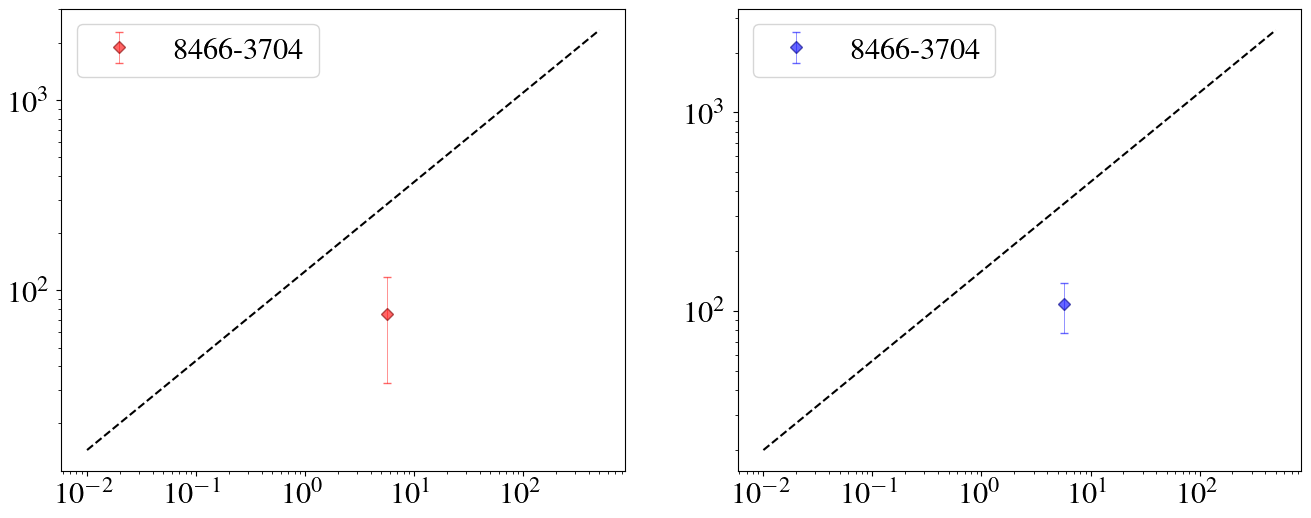

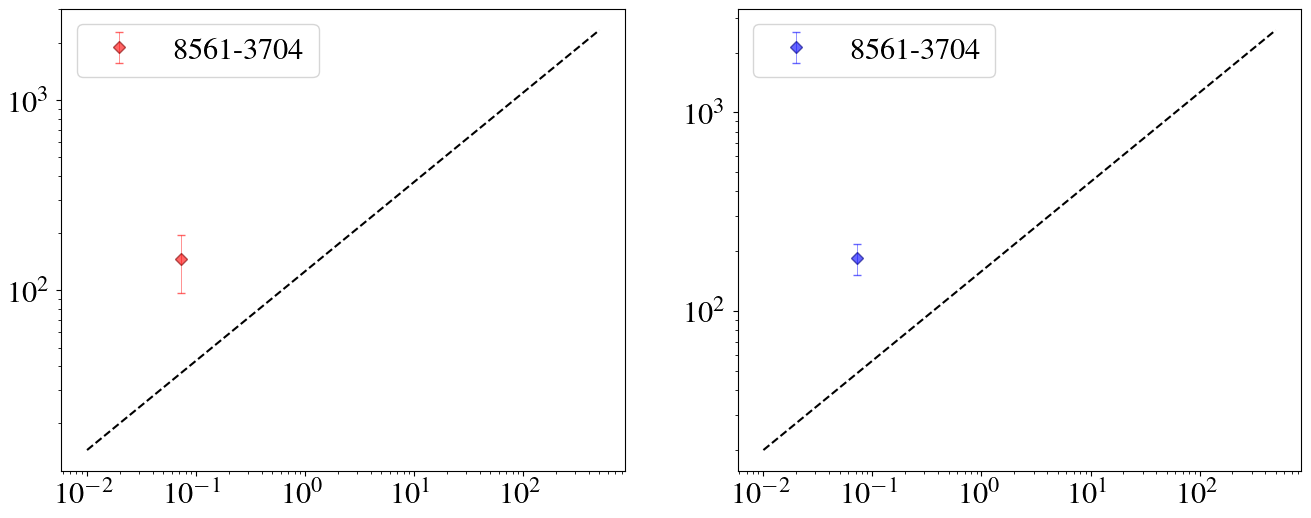

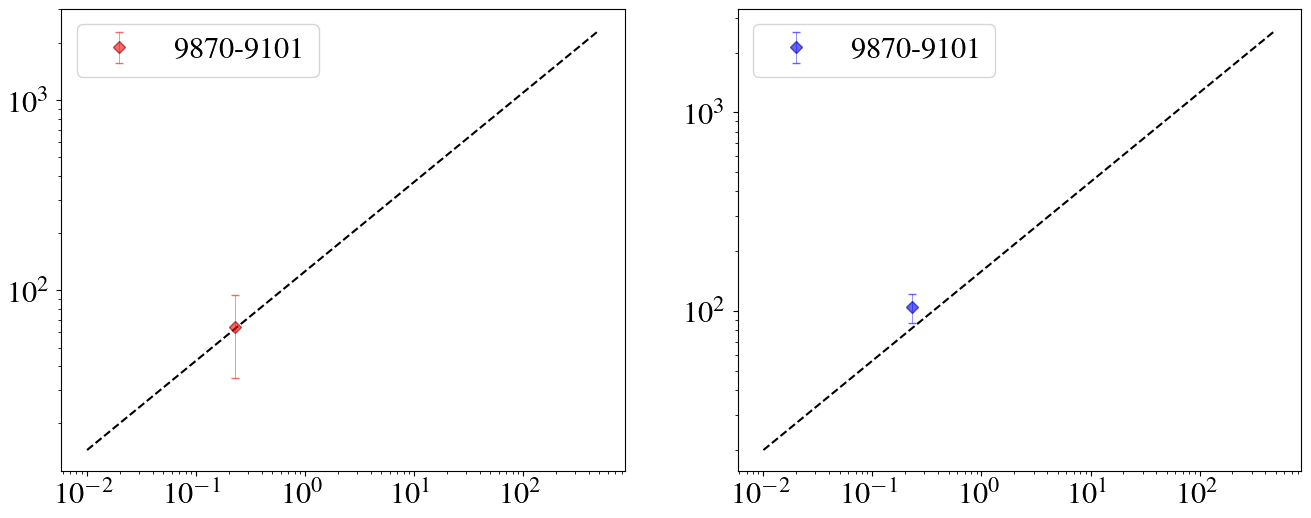

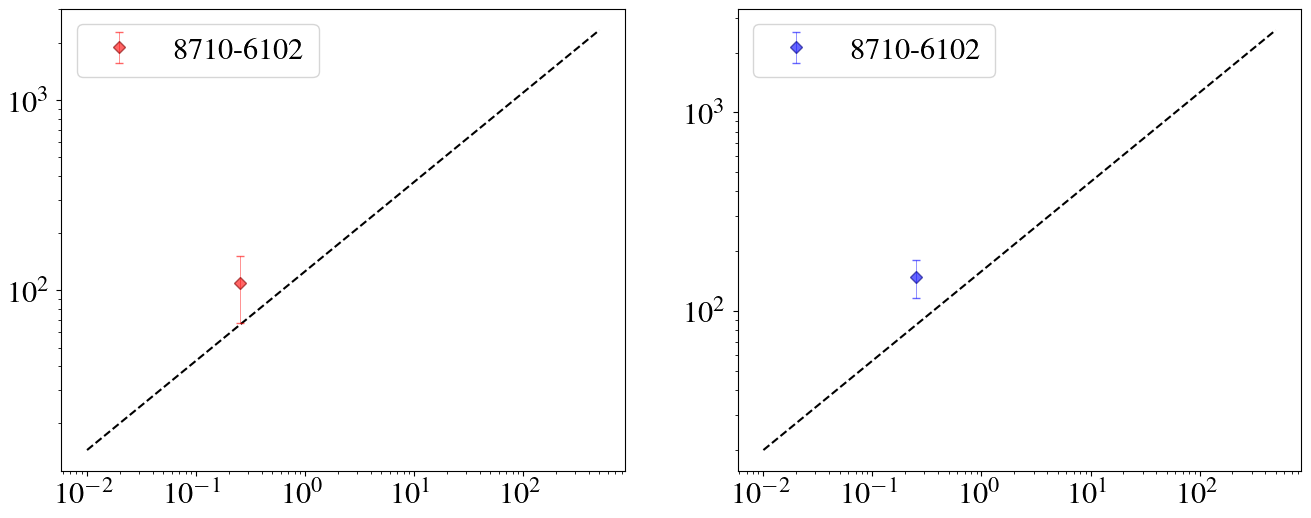

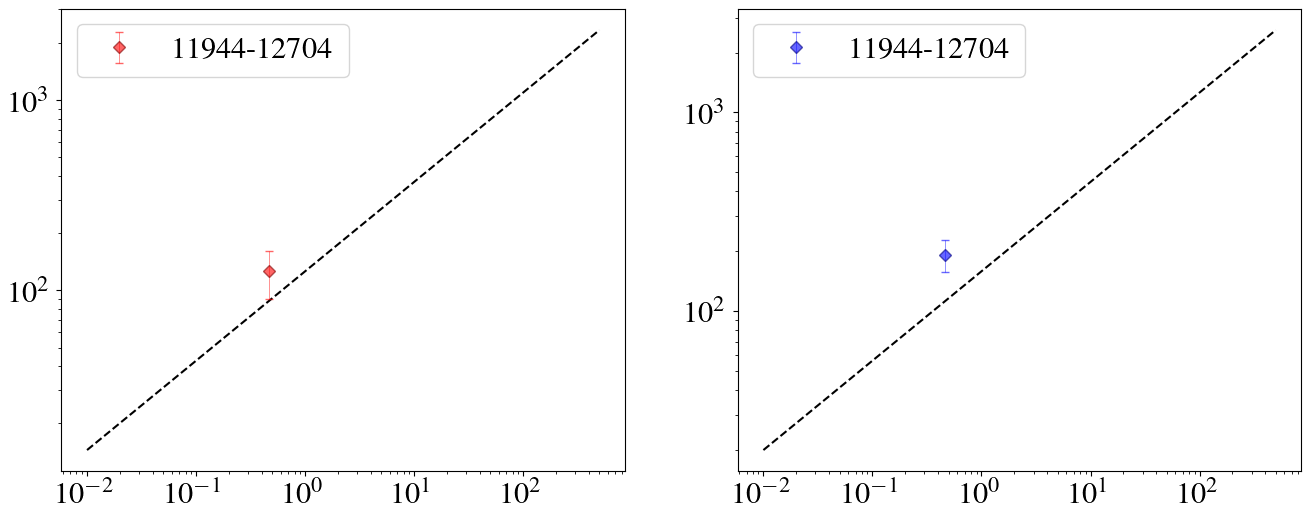

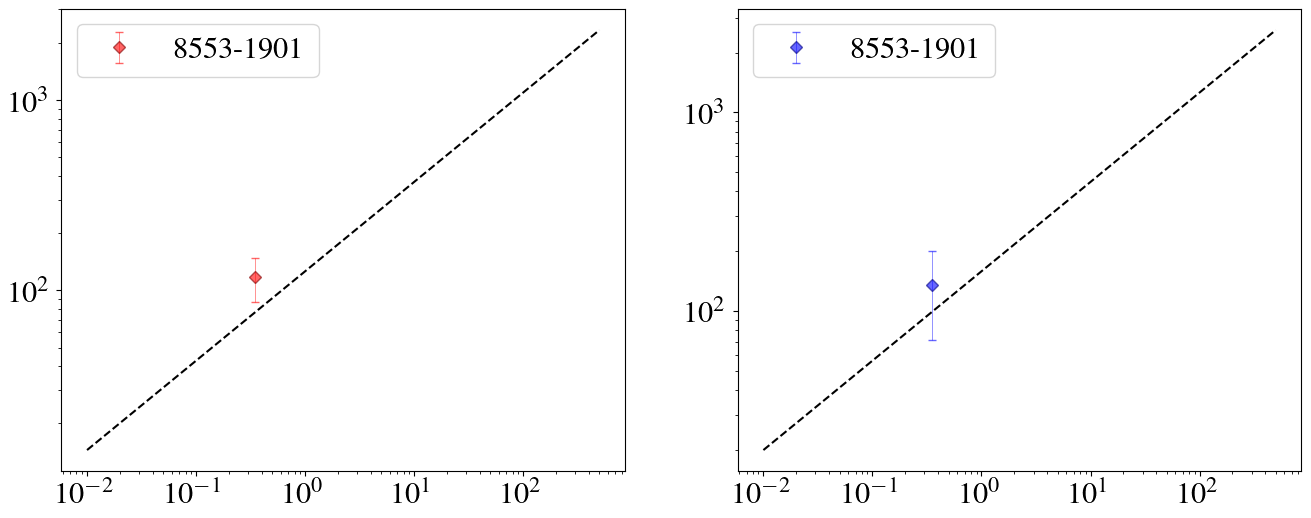

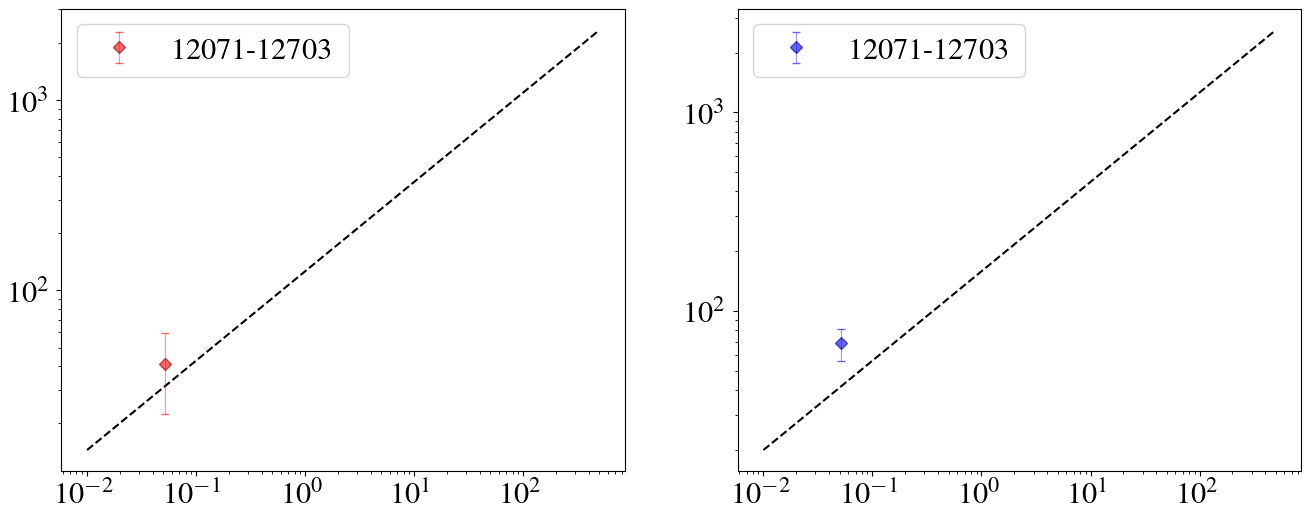

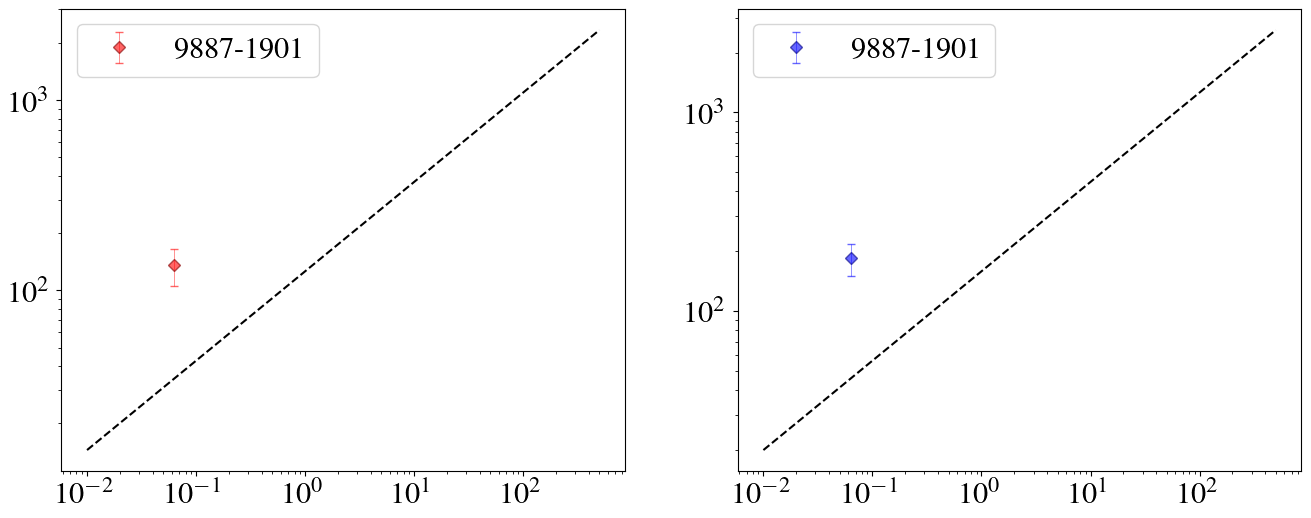

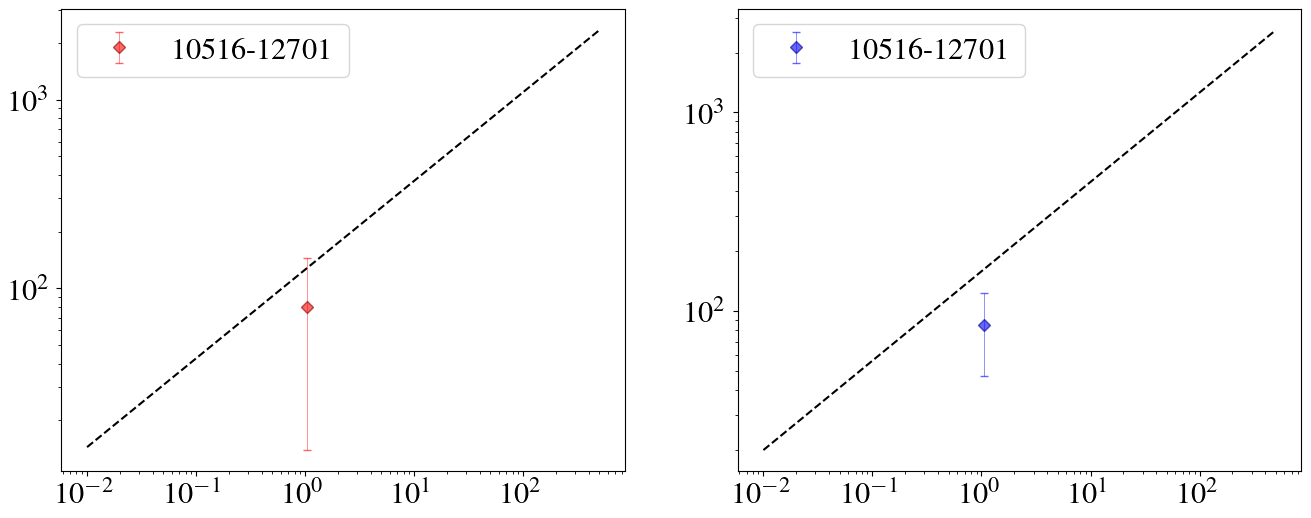

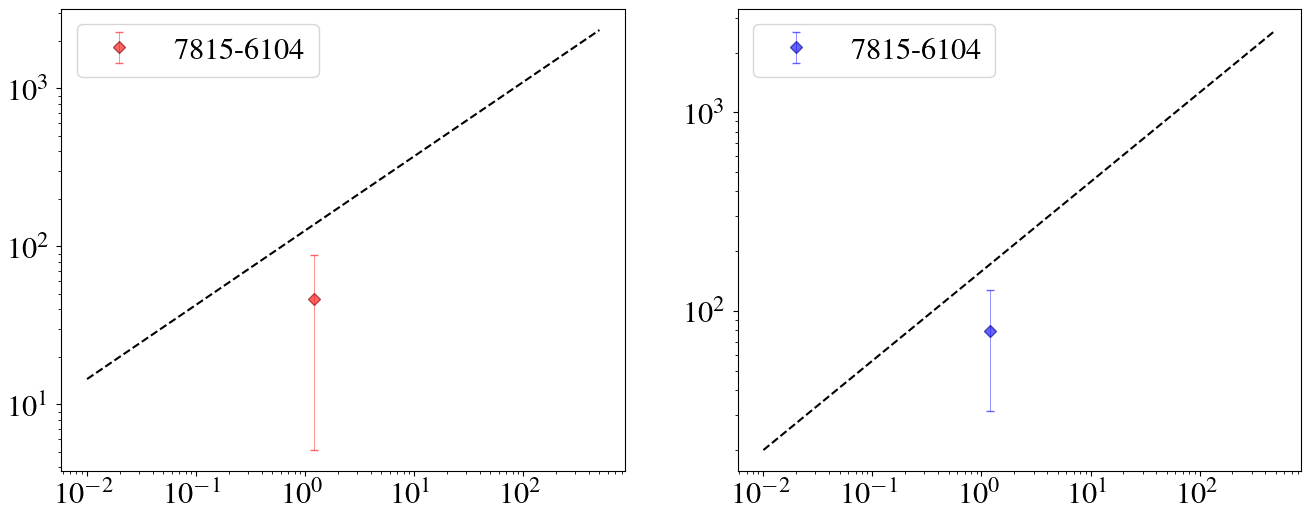

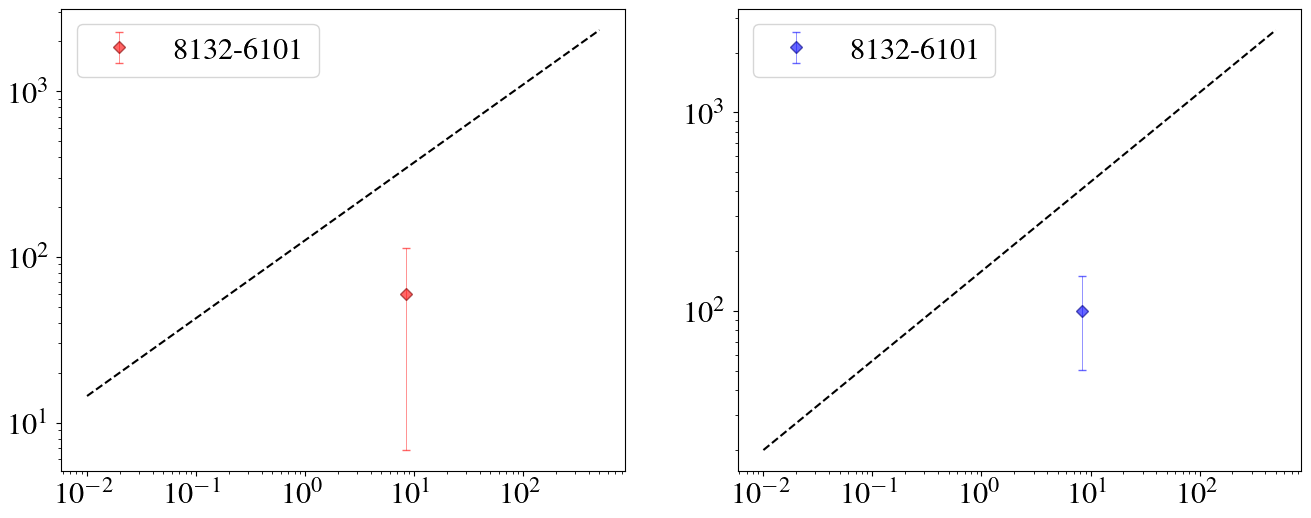

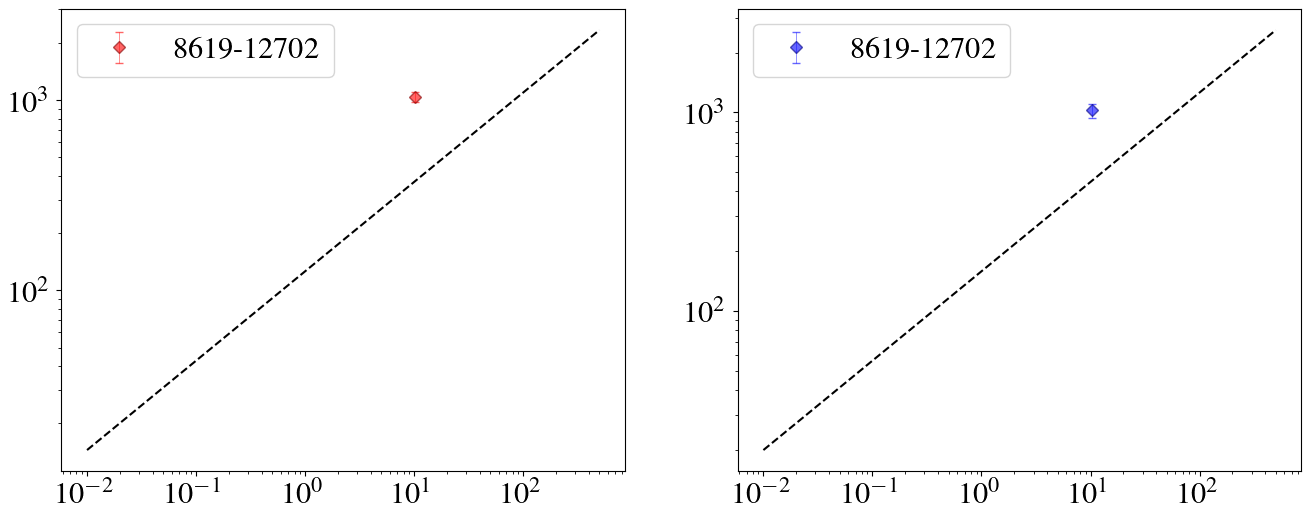

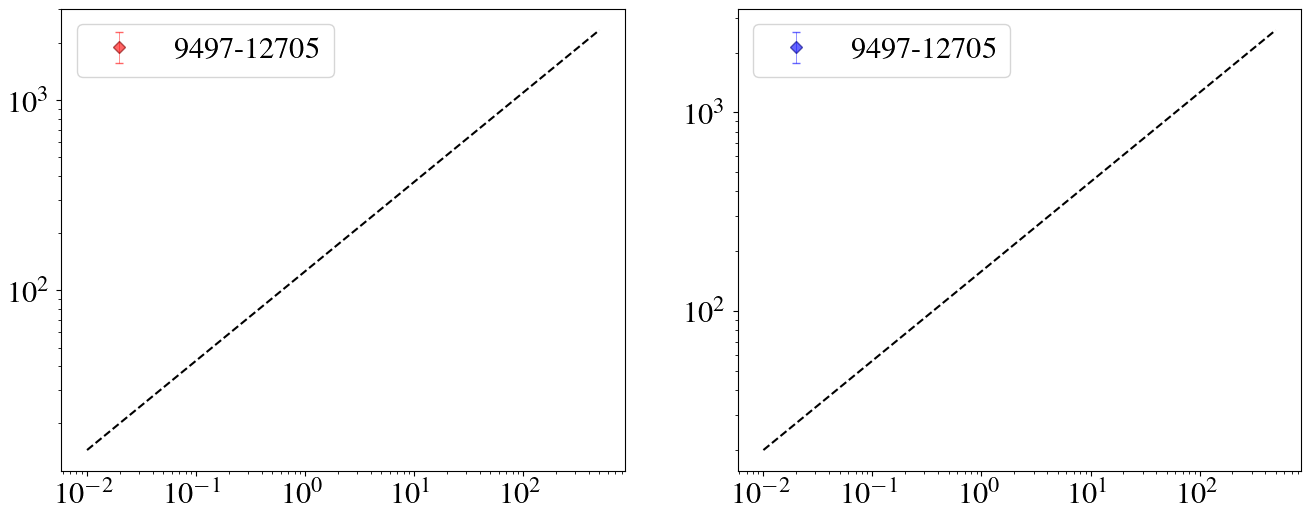

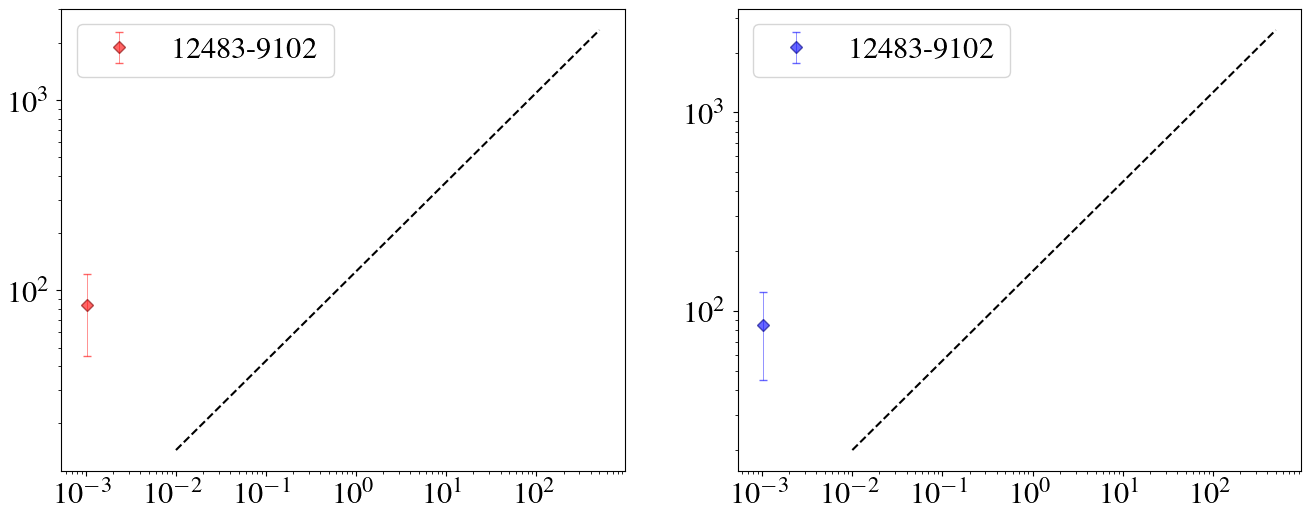

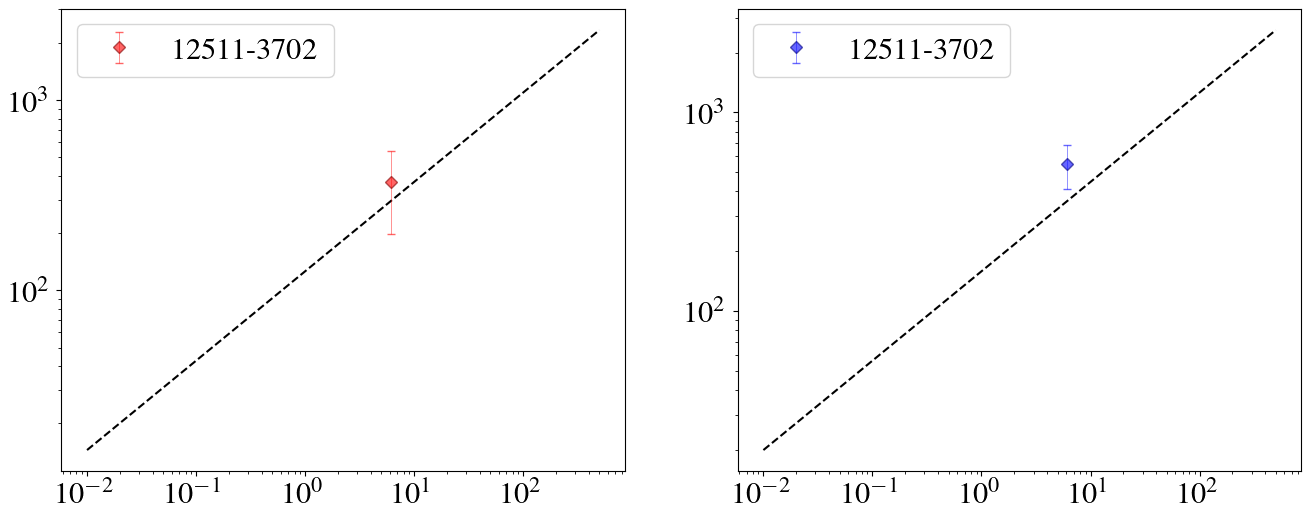

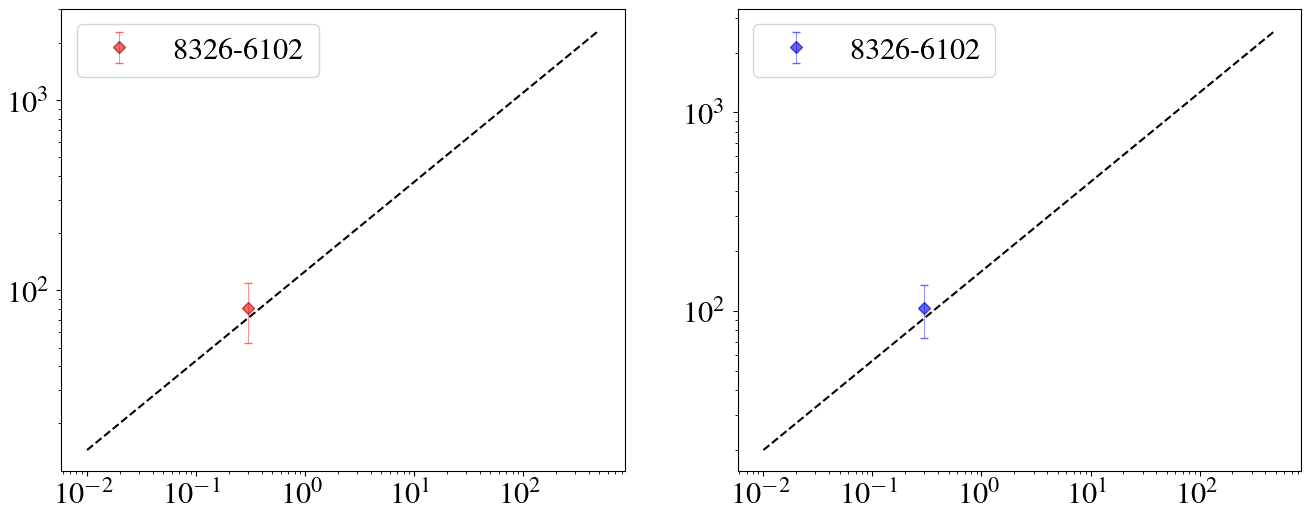

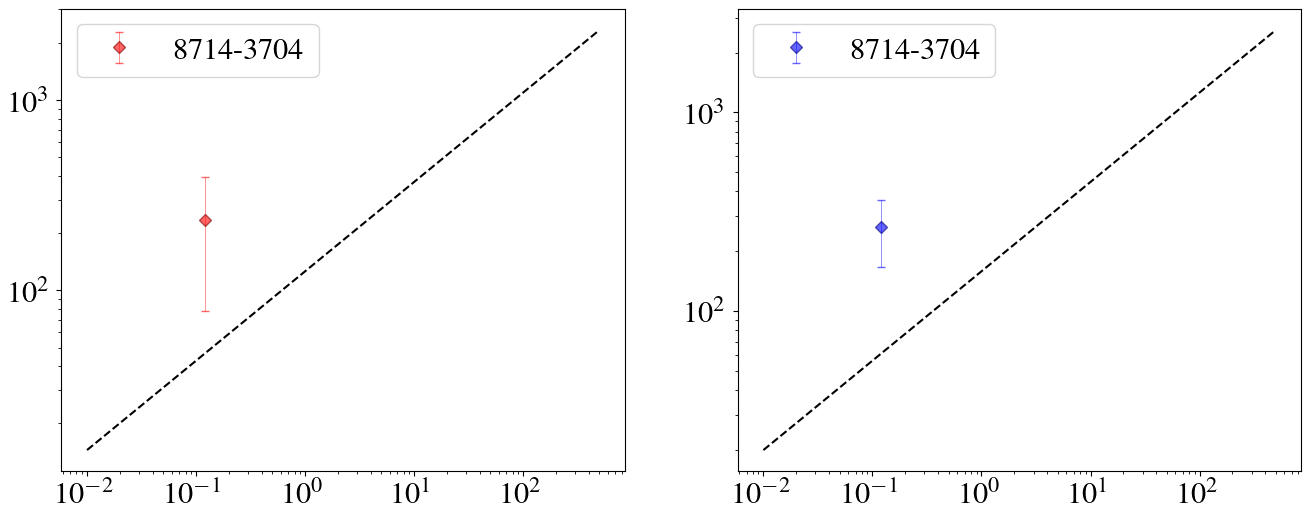

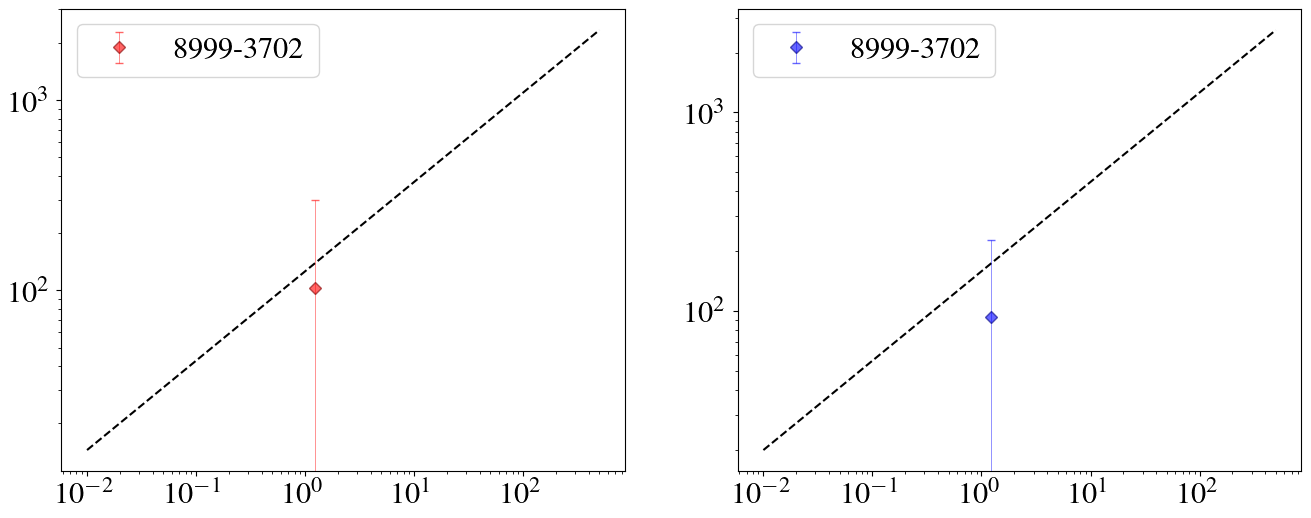

In [99]:
for j, pifu in enumerate(tab['plateifu'][flags]):
    i = np.where(tab['plateifu']==pifu)[0]
    fig, ax = plt.subplots(figsize=(16,6), ncols=2)
    ax[0].errorbar(10**logL_AGN[i], tab['lag_w1'][i], yerr=(w1_errmin[i]+w1_errmax[i])/2, elinewidth=0.5, ls='none', capsize=3, markeredgecolor='maroon', c='red', alpha=0.6, marker='D',ms=6, zorder=10, label=pifu)
    ax[0].plot(x, 10**2.1*x**0.47, c='k', ls='dashed', zorder=-2)

    ax[0].legend()
    ax[0].set_yscale('log')
    ax[0].set_xscale('log')

    ax[1].errorbar(10**logL_AGN[i], tab['lag_w2'][i],yerr=(w2_errmin[i]+w2_errmax[i])/2, elinewidth=0.5, ls='none', capsize=3, markeredgecolor='navy', c='blue', alpha=0.6, marker='D', ms=6, zorder=10, label=pifu)
    ax[1].plot(x, 10**2.2*x**0.45, c='k', ls='dashed', zorder=-2)

    ax[1].legend()
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')